![qqq](../resources/header.jpg)

**Машинное обучение**
***

О сайте **Backloggd.com**:

"**Backloggd** — это место для хранения вашей личной коллекции видеоигр. Каждая игра со всех платформ доступна для вас, чтобы вы могли войти в свой журнал. Следуйте за друзьями, чтобы поделиться своими отзывами и сравнить рейтинги. Затем используйте фильтры, чтобы отсортировать свою коллекцию и посмотреть, что для вас важно. Ведите список того, во что вы сейчас играете и во что хотите играть, и наблюдайте, как цифры меняются по мере того, как вы продолжаете записывать свои прохождения. Есть Goodreads для книг, Letterboxd для фильмов и теперь Backloggd для игр.

Все метаданные, связанные с игрой, поступают из базы данных **[IGDB](https://www.igdb.com/)**, управляемой сообществом . Сюда входят все данные об играх, компаниях и платформах, которые вы видите на сайте." - с сайта **[backloggd.com](https://www.backloggd.com/)**.

**Цель машинного обучения**: на основе подготовленных и предварительно обработанных данных,  обуитье модеьи, предсказываюуюй игровые жанры,к к которым принадлежит видеоигра с заданным описание    Выраатьтка сисуемы по оценке эффективности модели.

**Этапы машинного обучения**:
1. [Обзор данных](#Обзор-данных).
2. [Предобработка данных](#Предобработка-данных)
3. [Машинное обучение](#Машинное-обучение):
    - [Отбор данных](#Отбор-данных);
    - [Анализ баланса классов](#Анализ-баланса-классов);
    - [Предобработка текста](#Предобработка-текста);
    - [Разделение на выборки](#Разделение-на-выборки)
    - [Тестирование моделей](#Тестирование-моделей)
        - [Тестирование ComplementNB](#Тестирование-ComplementNB)
        - [Тестирование SGDClassifier](#Тестирование-SGDClassifier)
        - [Выводы по тестированию моделей](#Выводы-по-тестированию-моделей)
    - [Генерация признаков](#Генерация-признаков)
        - [ComplementNB](#ComplementNB)
        - [SGDClassifier](#SGDClassifier)
        - [Выводы по генерации признаков](#Выводы-по-генерации-признаков)
    - [Проверка модели на тестовой выборке](#Проверка-модели-на-тестовой-выборке)
4. [Выводы](#Выводы)
***

In [1]:
import sys

In [2]:
sys.path.append('C:\Projects\Backloggd\src')

In [3]:
from ast import literal_eval

import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer

from config.ml import FIT_CV_SPLITTING_STRATEGY
from config.ml import FIT_CV_VERBOSE
from config.ml import LEARNING_CURVE_N_SPLITS
from config.ml import LEARNING_CURVE_TEST_SIZE
from config.ml import LEARNING_CURVE_TRAIN_SIZES
from config.ml import N_JOBS
from config.ml import RANDOM_STATE
from config.paths import PATH_PREPROCESSED_DATA
from utils import plot
from utils.explorer import explorer

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gsimo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
sns.set_style('white')

In [6]:
RANDOM_STATE = 42

In [7]:
print(explorer(PATH_PREPROCESSED_DATA, ext='*.csv'))

1. backloggd.csv.


In [8]:
file = fr'{PATH_PREPROCESSED_DATA}\backloggd.csv'

# Обзор данных
***

In [9]:
df = pd.read_csv(file)

In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121907 entries, 0 to 121906
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  121907 non-null  object
 1   genres       121907 non-null  object
dtypes: object(2)
memory usage: 49.7 MB


In [11]:
pd.concat([
    df.head(),
    df.sample(5),
    df.tail()
])

description  \
0       the cathode ray tube amusement device the earl...   
1       currently consider the first videogame history...   
2       the nimrod be special purpose computer that pl...   
3       a game draught checker write for the ferranti ...   
4       oxo be computer game developed alexander dougl...   
67267   lead your troop silver back gorilla raise fami...   
29676   it christmas eve and dinky angry after return ...   
88431   mercenaries rebirth tactical rpg set fantasy w...   
116067  the four character from left dead join the res...   
88759   a deadly game tag queen vanessa manor escape t...   
121902  strange town very fun multiplayer and local mu...   
121903  cold engines rts where you need survive harsh ...   
121904  dust raiders management strategy game set lawl...   
121905  a platform fight game feature many spooky vide...   
121906  dance killer trick boys dancing otome breeding...   

                                   genres  
0                     ['Point-and-Click']  
1                  ['Puzzle', 'Tactical']  
2                            ['Strategy']  
3                   ['Card & Board Game']  
4                  ['Puzzle', 'Strategy']  
67267   ['Adventure', 'RPG', 'Simulator']  
29676                         ['Shooter']  
88431     ['RPG', 'Strategy', 'Tactical']  
116067                        ['Shooter']  
88759                       ['Adventure']  
121902          ['Adventure', 'Strategy']  
121903                       ['Strategy']  
121904                       ['Strategy']  
121905                       ['Fighting']  
121906                          ['Music']

# Машинное обучение
***

## Разделение на выборки
***

In [12]:
x = df['description']
y = df['genres']

In [13]:
y = y.apply(literal_eval)

In [14]:
encoder = MultiLabelBinarizer()
encoder.fit(y)
y = pd.DataFrame(encoder.transform(y))
labels = pd.Series(encoder.classes_)

In [15]:
labels

0               Adventure
1                  Arcade
2                 Brawler
3       Card & Board Game
4                Fighting
5                   Music
6                Platform
7         Point-and-Click
8                  Puzzle
9             Quiz/Trivia
10                    RPG
11                 Racing
12     Real Time Strategy
13                Shooter
14              Simulator
15                  Sport
16               Strategy
17               Tactical
18    Turn Based Strategy
19           Visual Novel
dtype: object

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x, 
    y,
    shuffle=True, 
    test_size=0.3,
    random_state=RANDOM_STATE
)

In [17]:
x_valid, x_test, y_valid, y_test = train_test_split(
    x_valid, 
    y_valid, 
    shuffle=True, 
    test_size=0.5,
    random_state=42
)

In [18]:
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

In [19]:
pd.DataFrame(
    data={
        'X': [x_train.shape, x_valid.shape, x_test.shape],
        'Y': [y_train.shape, y_valid.shape, y_test.shape],
    },
    index=['train', 'valid', 'test']
)

X            Y
train  (85334,)  (85334, 20)
valid  (18286,)  (18286, 20)
test   (18287,)  (18287, 20)

## Анализ баланса классов
***

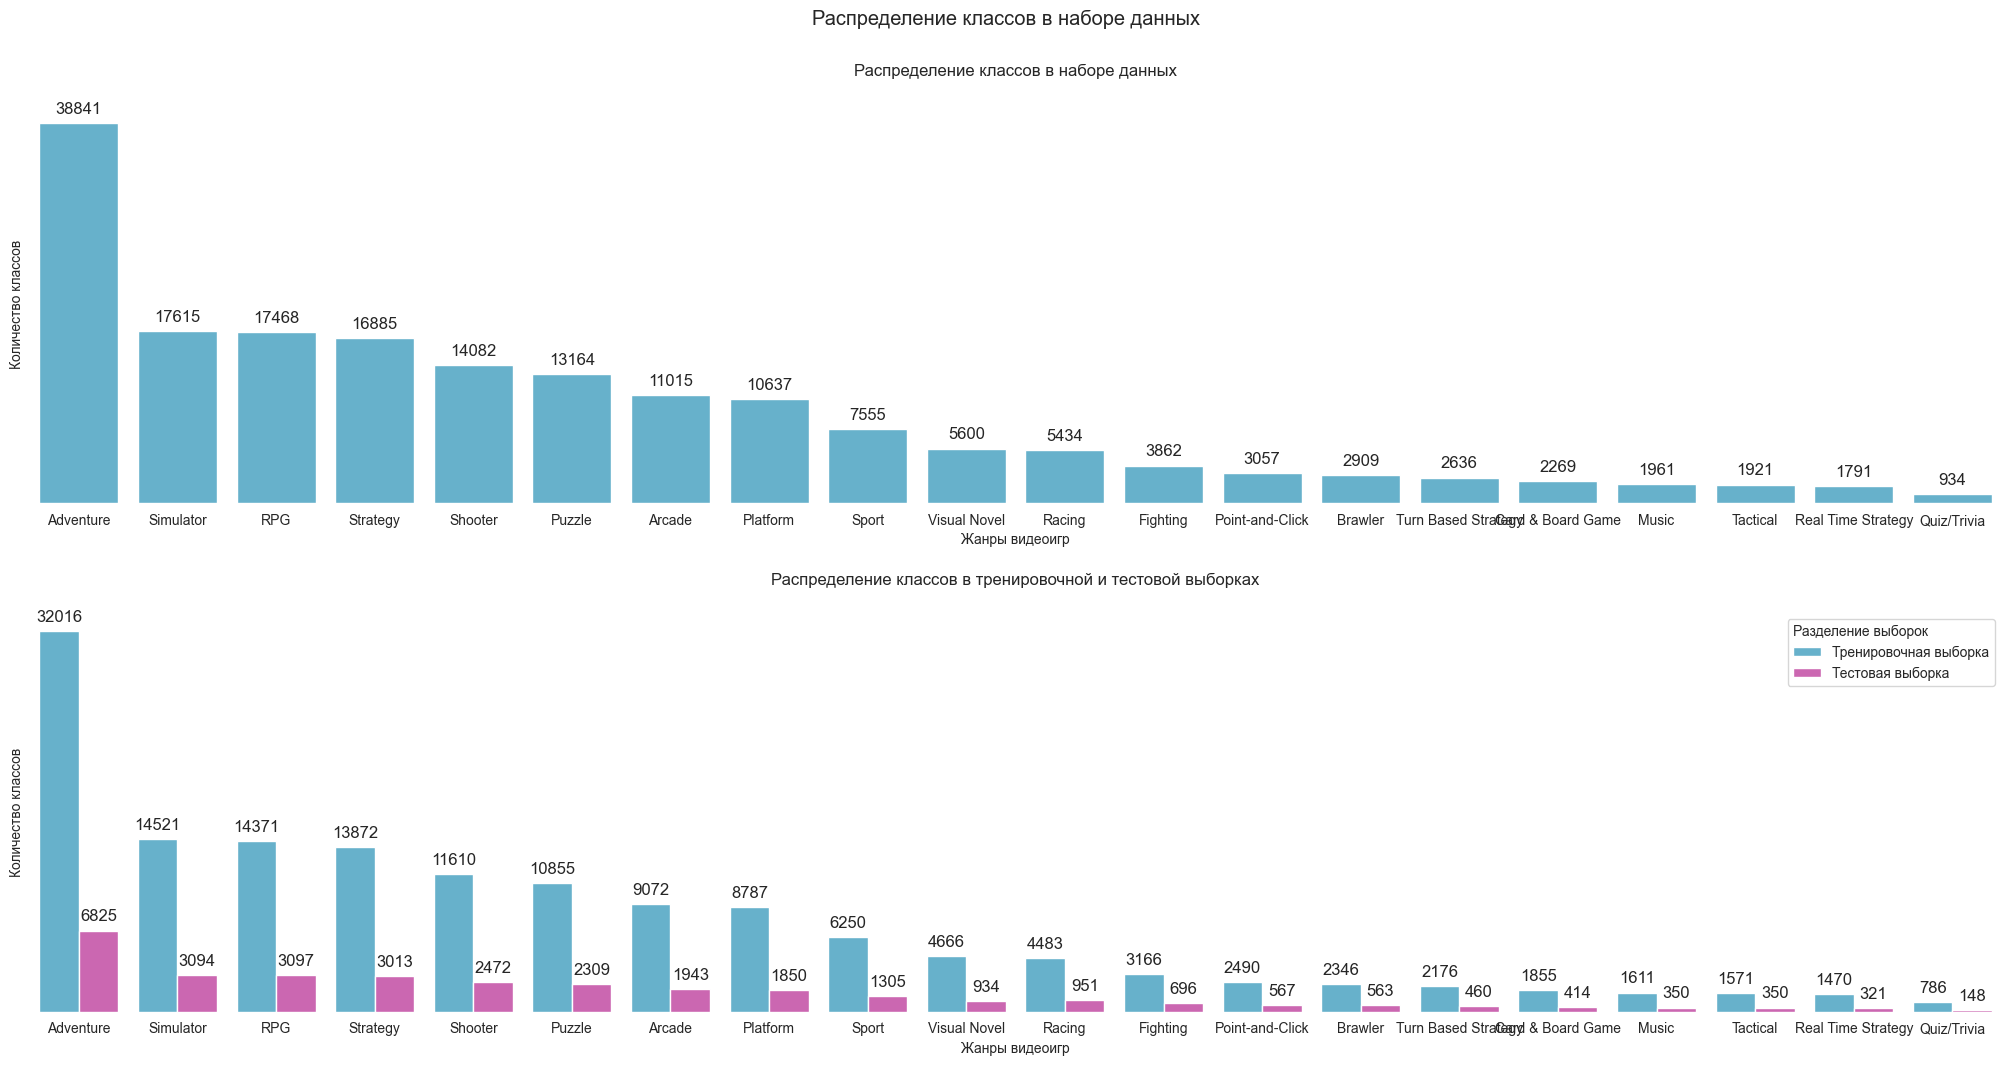

In [20]:
plot.balance(y_train, y_valid, labels)

В наборе данных **присутствует дисбаланс классов**. **Мажоритарным** классом является класс **Adventure** (количество экземпляров более **29 тыс.**). **Миноритарным** классом является класс **Quiz/Trivia** (количество экземпляров менее **1 тыс.**). **Остальные** классы имеют от **800** до **13 тыс.** экземпляров.

## Частотный анализ

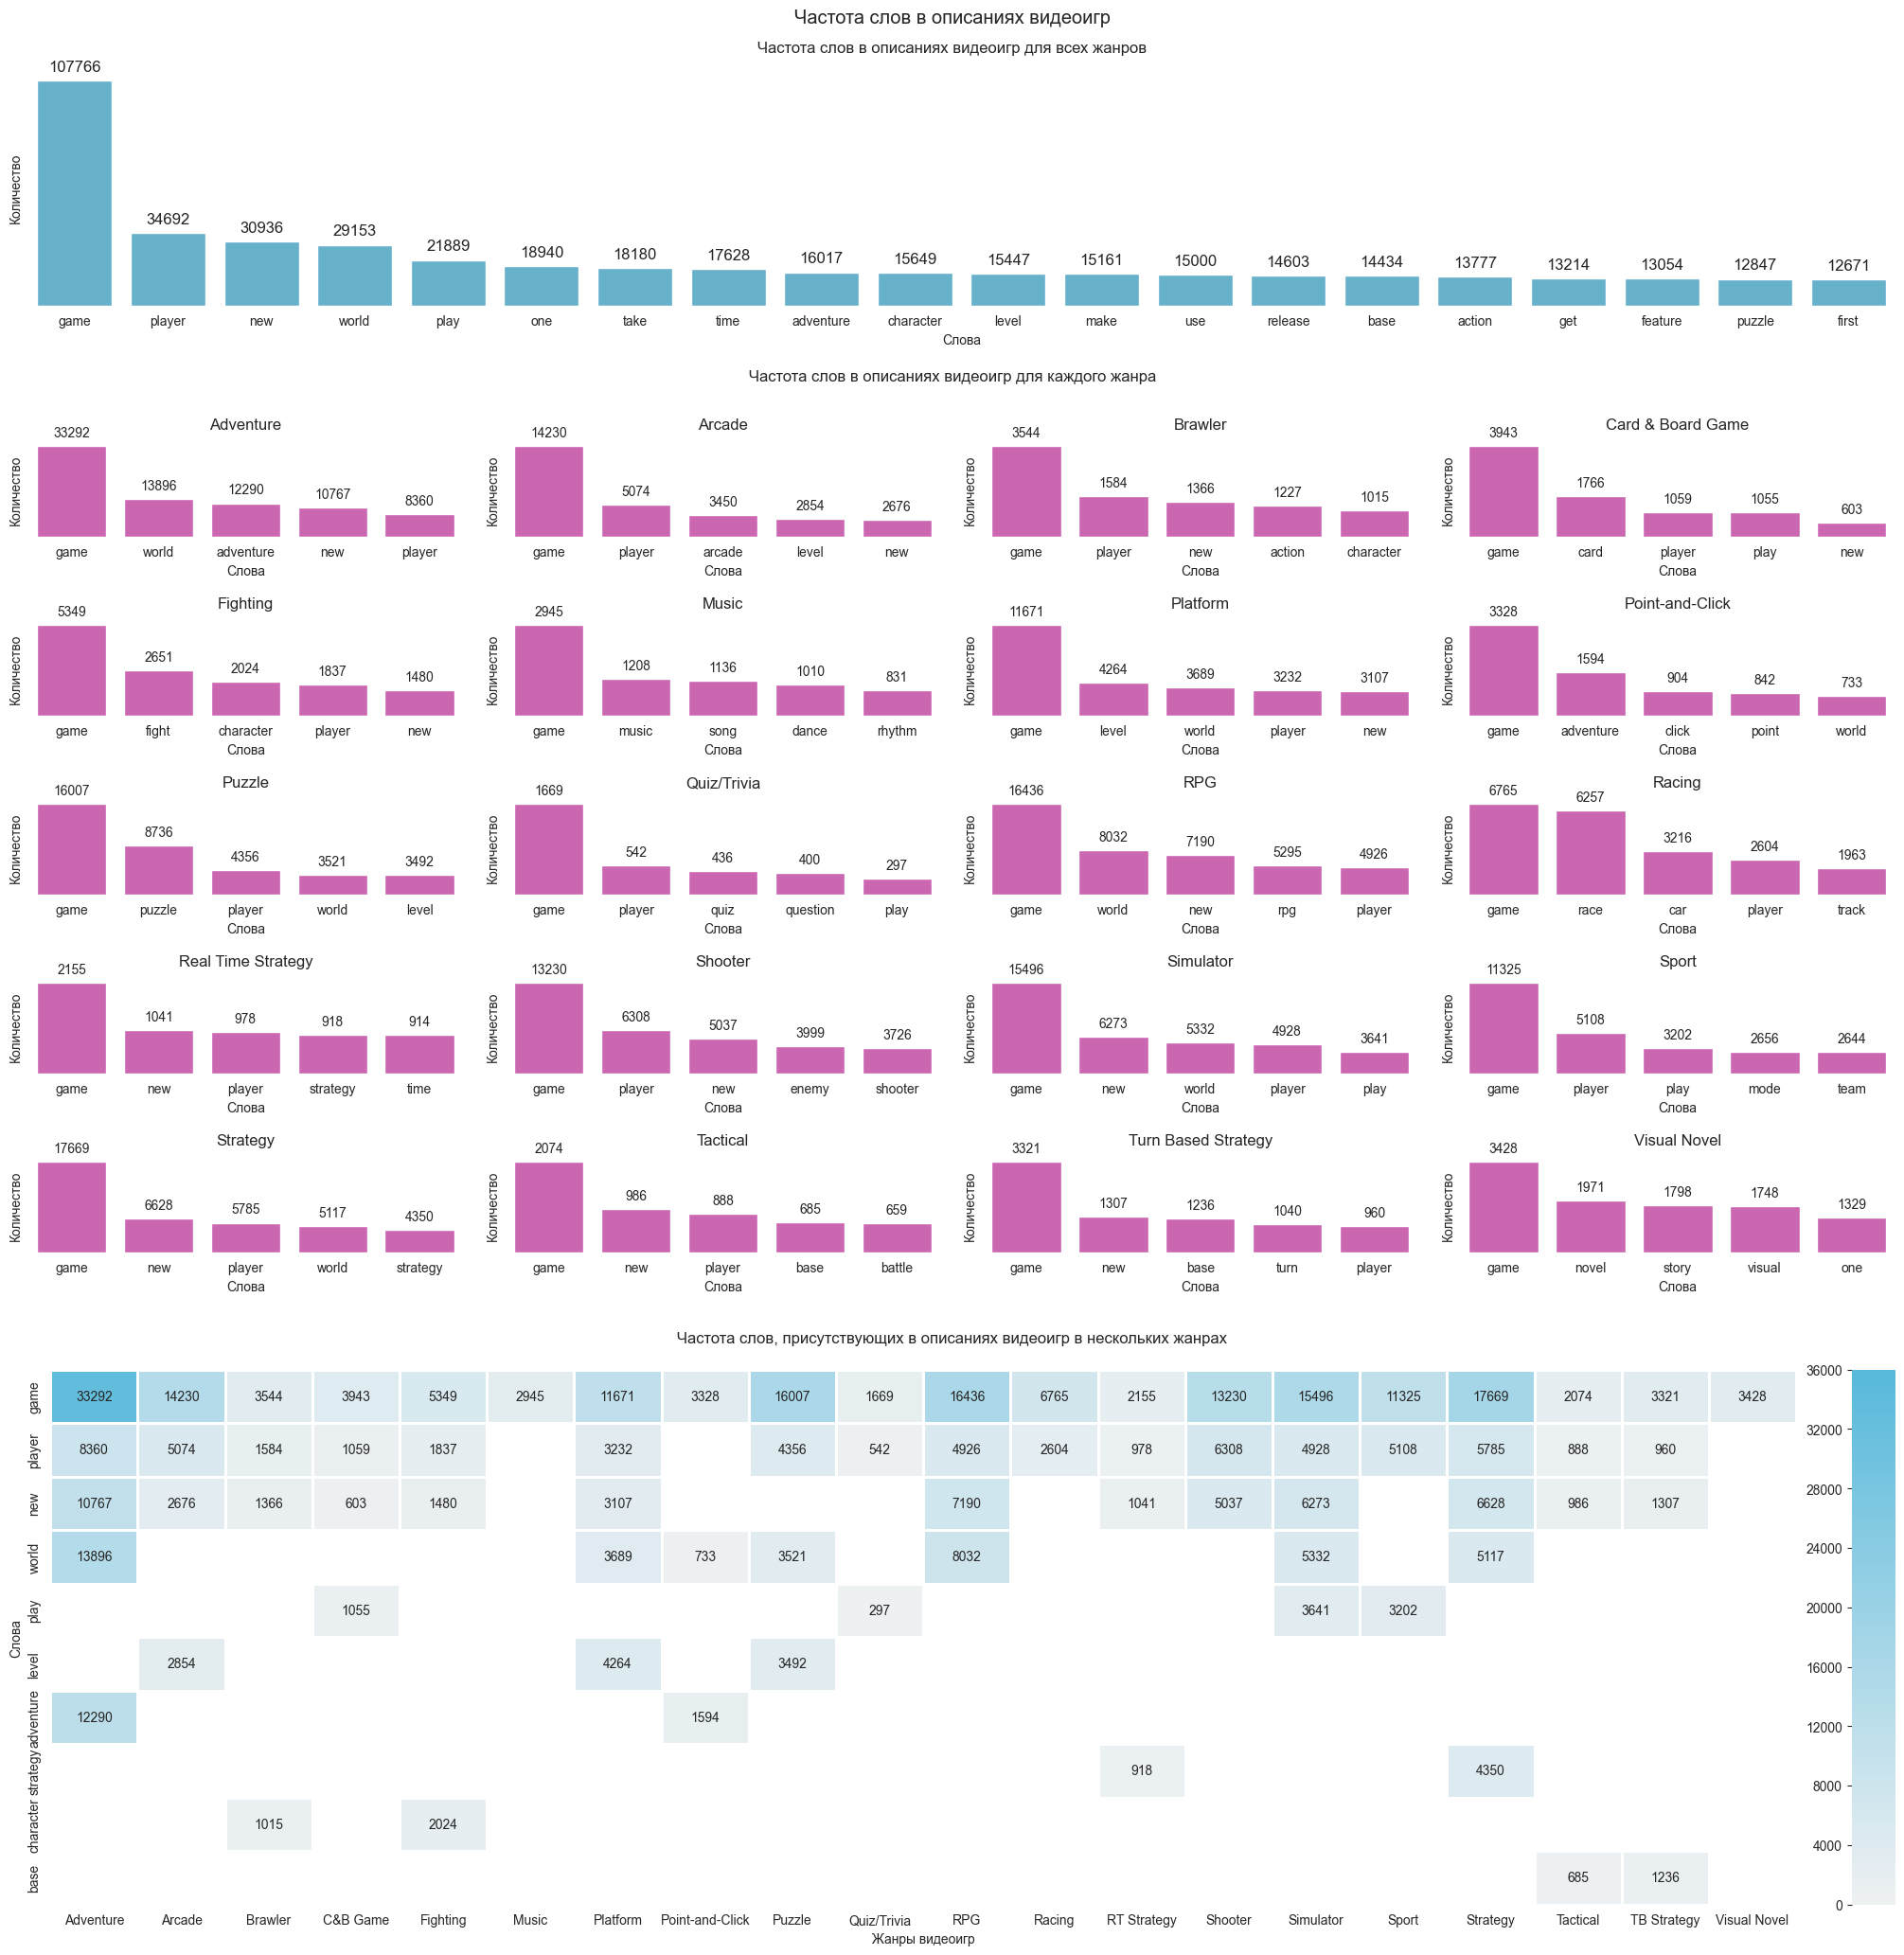

In [21]:
plot.words(
    data=pd.concat([x, y], axis=1),
    labels=labels,
    stop_words=stopwords.words('english')
)

Наиболее часто в описаниях видеоигр встречается слово **game** (приблизительно **70 тыс.** раз). **Остальные слова** встречаются в описаниях видеоигр менее **20 тыс.** раз. Для каждого класса существует свой **уникальный** список наиболее часто встречающихся слов в описаниях видеоигр.

## Тестирование моделей
***

Для стандартизации признаков используем **TfidfVectorizer**.

In [22]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words=stopwords.words('english')
)

standardizer = Pipeline(
    steps=[
        ('vectorizer', vectorizer)
    ]
)
standardizer

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...]))])

Для оценки эффективности **предсказательной способности** модели, будем использовать метрику **f1-weighted**.

In [23]:
f1_weighted = make_scorer(
    score_func=f1_score,
    average='weighted',
    zero_division=0.0
)

В для оценки эффективности были выбраны следующие показатели:
- время обучения;
- время предсказания;
- f1-weighted.

In [24]:
results = pd.DataFrame(
    columns=['Время обучения', 'Время предсказания', 'f1-weighted'],
    index=['ComplementNB', 'SGDClassifier']
)
results.style.format(na_rep='-')

### Тестирование ComplementNB
***

In [25]:
estimator = ComplementNB()
estimator = MultiOutputClassifier(
    estimator=estimator,
    n_jobs=4
)

pipeline = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator)
    ]
)
pipeline

Pipeline(steps=[('standardizer',
                 Pipeline(steps=[('vectorizer',
                                  TfidfVectorizer(stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
                                                              'your', 'yours',
                                                              'yourself',
                                                              'yourselves',
                                                              'he', 'him',
                                                              'his', 'himself',
                                                              'she', "she's",
                                                              'her', 'hers',
                                                              'herself', 'it',
                                                              "it's", 'its',
                                                              'itself', ...]))])),
                ('estimator',
                 MultiOutputClassifier(estimator=ComplementNB(), n_jobs=4))])

In [26]:
param_grid = {
    'standardizer__vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'standardizer__vectorizer__norm': [None, 'l1', 'l2'],
    'standardizer__vectorizer__sublinear_tf': [True, False],
    'standardizer__vectorizer__max_features': np.arange(
        start=500_000,
        stop=1_000_001,
        step=250_000
    ).tolist(),
    'estimator__estimator__norm': [False, True],
    'estimator__estimator__alpha': np.linspace(
        start=1.0,
        stop=10.0,
        num=10
    ).round(5).tolist()
}

In [27]:
%%time
complement_nb = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions=param_grid, 
    scoring=f1_weighted,
    error_score=0.0,
    n_iter=20,
    cv=2, 
    verbose=3,
    refit=True
)
complement_nb.fit(x_train, y_train); 

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2] END estimator__estimator__alpha=5.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=750000, standardizer__vectorizer__ngram_range=(1, 2), standardizer__vectorizer__norm=l1, standardizer__vectorizer__sublinear_tf=False;, score=0.073 total time=  33.6s
[CV 2/2] END estimator__estimator__alpha=5.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=750000, standardizer__vectorizer__ngram_range=(1, 2), standardizer__vectorizer__norm=l1, standardizer__vectorizer__sublinear_tf=False;, score=0.073 total time=  41.8s
[CV 1/2] END estimator__estimator__alpha=6.0, estimator__estimator__norm=False, standardizer__vectorizer__max_features=500000, standardizer__vectorizer__ngram_range=(1, 3), standardizer__vectorizer__norm=l1, standardizer__vectorizer__sublinear_tf=False;, score=0.073 total time=  49.4s
[CV 2/2] END estimator__estimator__alpha=6.0, estimator__estimator__norm=False, s

In [28]:
cv_results = pd.DataFrame(
    data=complement_nb.cv_results_, 
).sort_values('rank_test_score')
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
19       3.765259      0.329329         4.534705        1.200523   
6        6.360979      0.172532         7.628446        1.616218   
15      17.791274      0.110371         7.665167        0.173322   
13       7.308357      1.313301         5.781666        1.522827   
9       29.055789      1.629720        15.904784        2.174741   
3       22.040629      1.197255        14.866698        4.265460   
4       24.170808      1.346635        21.663836        6.557096   
11      38.576334      4.767152        15.202082        1.004935   
5       45.429015      9.010045        19.015953        2.878084   
14      12.297607      0.925165         7.590372        1.161474   
18      17.733687      0.027564         7.553145        0.162974   
17      10.703361      0.013280         6.426772        0.051500   
10      21.528446      2.881866        11.495252        1.477120   
1       38.752512      1.143634        11.520950        0.323007   
0       19.351247      2.332234        18.459378        1.778516   
8       49.490533      3.699887        26.872055        1.086943   
16       2.936223      0.009140         2.801754        0.021281   
7       22.367595      2.272137        12.483241        1.826303   
2        6.219405      1.025531         6.076452        0.353666   
12       4.672416      0.232926         5.074125        0.969338   

   param_standardizer__vectorizer__sublinear_tf  \
19                                        False   
6                                         False   
15                                        False   
13                                        False   
9                                          True   
3                                         False   
4                                         False   
11                                         True   
5                                         False   
14                                         True   
18                                         True   
17                                         True   
10                                        False   
1                                         False   
0                                         False   
8                                          True   
16                                        False   
7                                         False   
2                                          True   
12                                         True   

   param_standardizer__vectorizer__norm  \
19                                 None   
6                                    l2   
15                                   l2   
13                                   l2   
9                                    l2   
3                                    l2   
4                                    l2   
11                                   l2   
5                                    l2   
14                                   l2   
18                                   l2   
17                                   l1   
10                                   l2   
1                                    l1   
0                                    l1   
8                                    l1   
16                                   l2   
7                                    l1   
2                                    l1   
12                                   l1   

   param_standardizer__vectorizer__ngram_range  \
19                                      (1, 1)   
6                                       (1, 1)   
15                                      (1, 3)   
13                                      (1, 1)   
9                                       (1, 2)   
3                                       (1, 2)   
4                                       (1, 2)   
11                                      (1, 3)   
5                                       (1, 3)   
14                                      (1, 2)   
18                                      (1, 3)   

In [29]:
results.loc['ComplementNB', 'Время обучения'] = cv_results.iloc[0, -3]
results.loc['ComplementNB', 'Время предсказания'] = cv_results.iloc[0, -3]
results.loc['ComplementNB', 'f1-weighted'] = cv_results.iloc[0, -3]

In [30]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=complement_nb.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=ShuffleSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE,
        random_state=RANDOM_STATE
    ),
    n_jobs=N_JOBS,
    scoring=f1_weighted,
    return_times=True,
    verbose=3
)

[learning_curve] Training set sizes: [  682  3413 13653 27306 40960 54613 68267]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:   37.5s remaining:  1.2min
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:  1.4min remaining:   39.4s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  2.1min finished


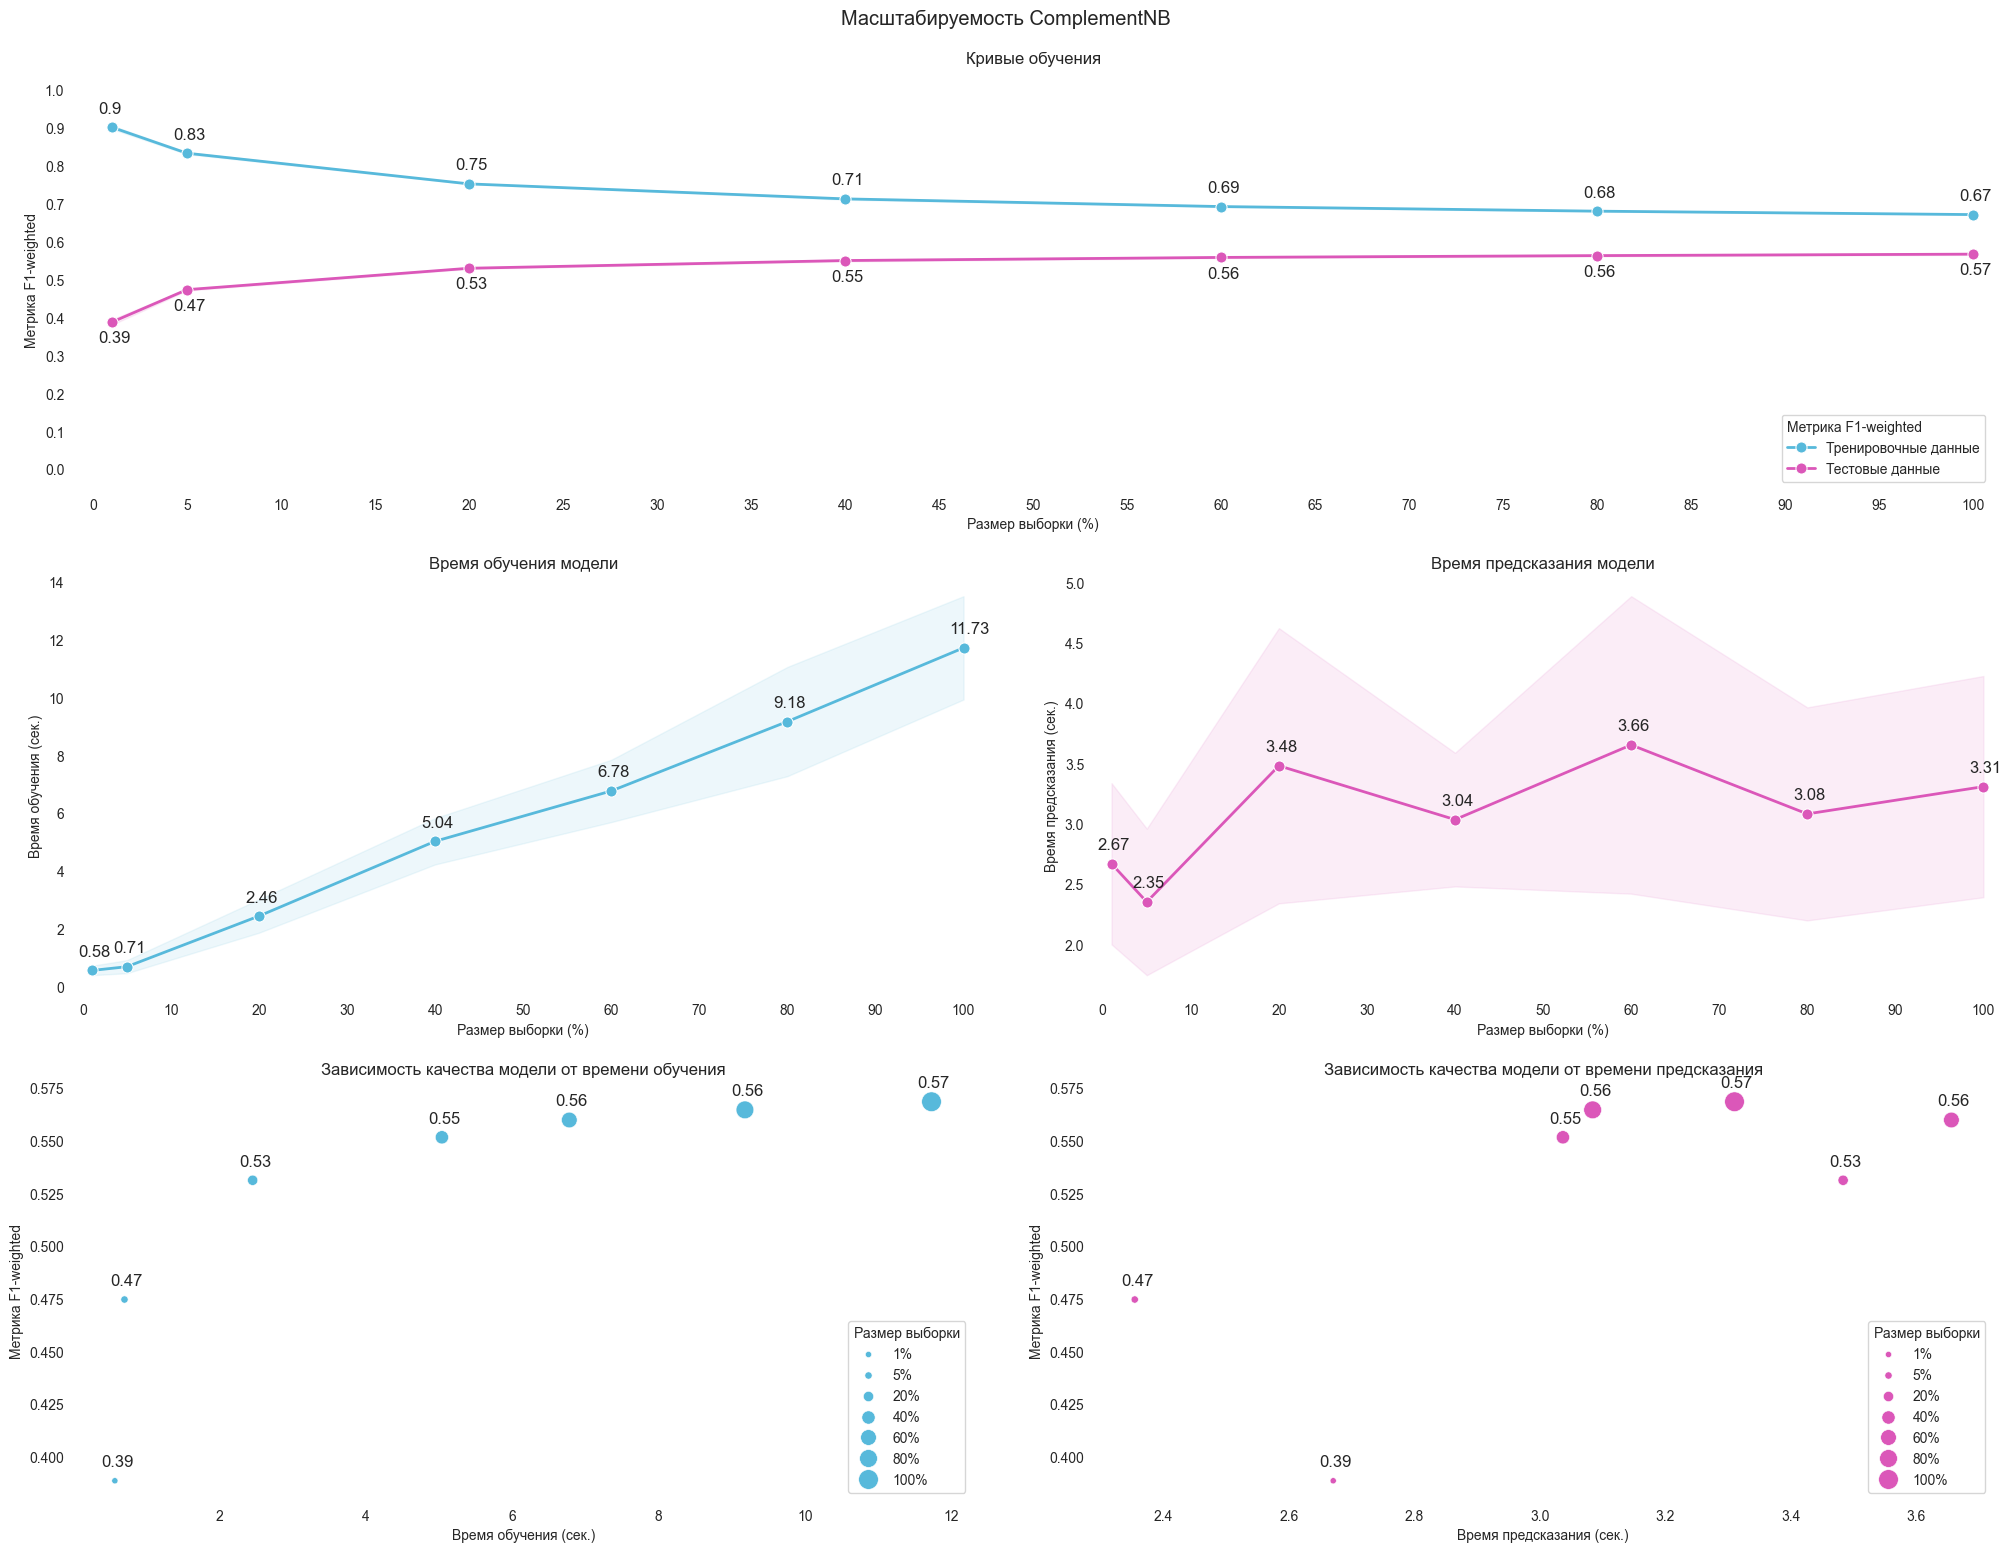

In [31]:
x_train_size = x_train.shape[0]
x_train_size *= (1 - LEARNING_CURVE_TEST_SIZE)
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость ComplementNB',
)

Кривые обучения показывают, что **присутствует** признак переобучения модели. **Добавление новых данных** возможно **улучшит** предсказательную способность модели. При добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.

In [32]:
predict = complement_nb.predict(x_valid)
predict_proba = complement_nb.predict_proba(x_valid)

In [33]:
f1 = f1_score(
    y_true=y_valid,
    y_pred=predict,
    average='weighted'
)

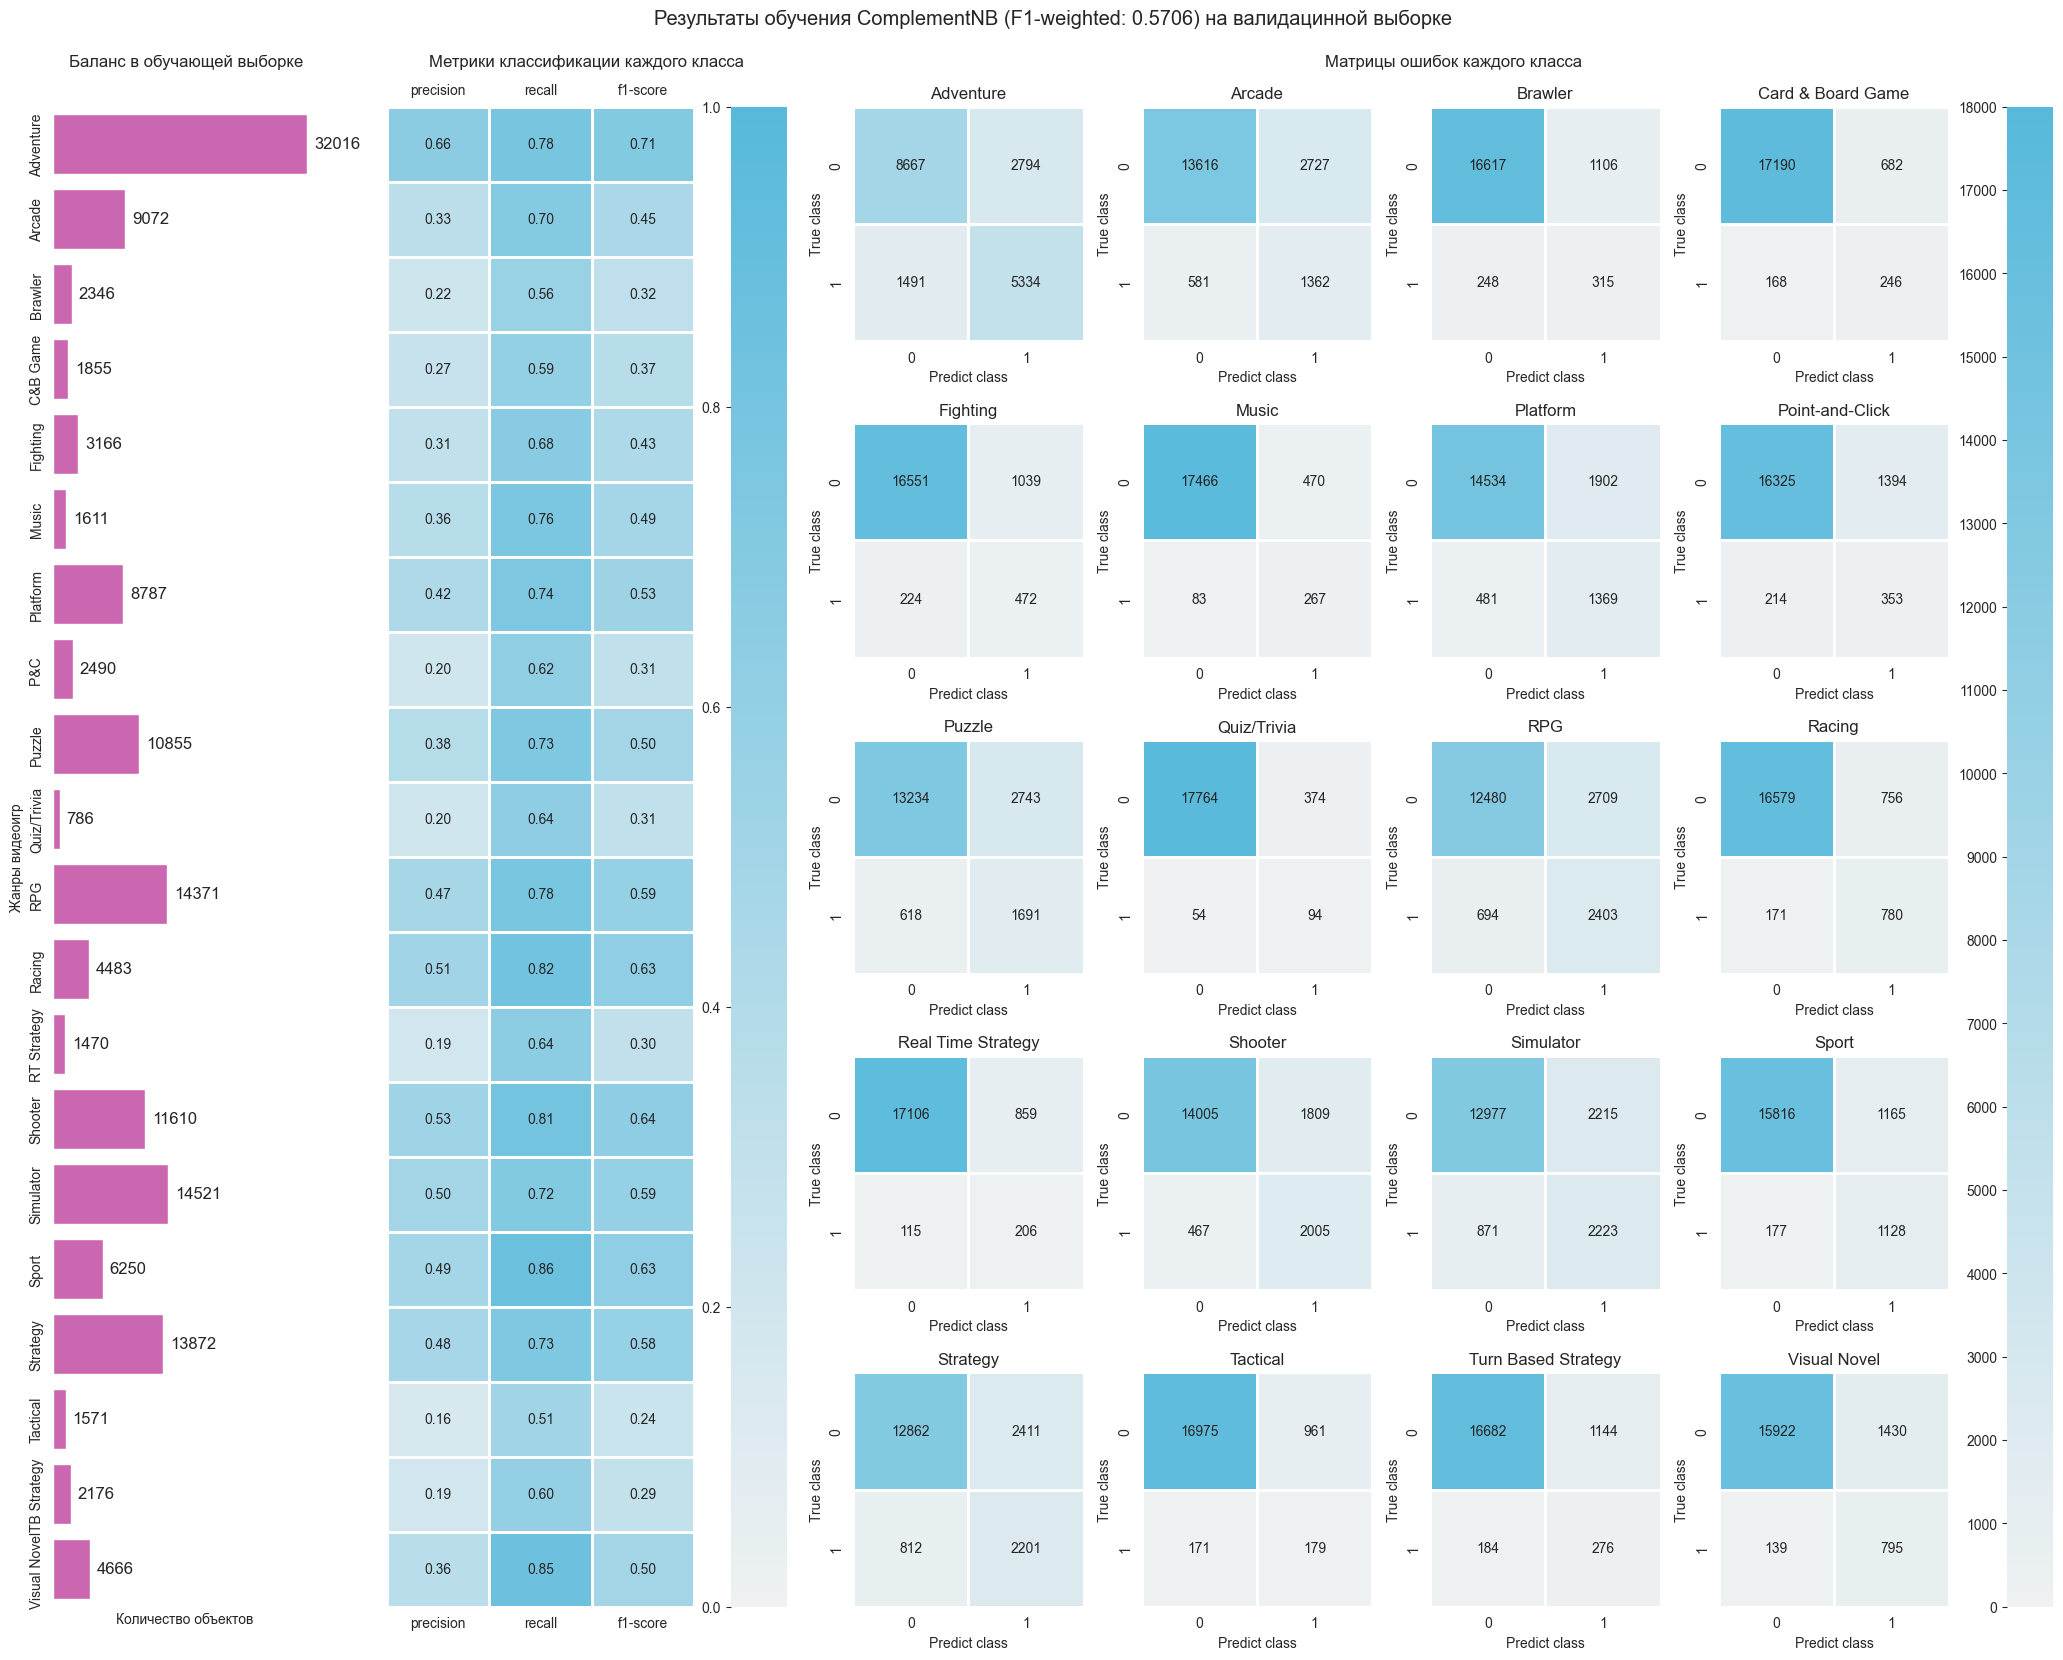

In [34]:
plot.metrics(
    y_test=y_valid,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения ComplementNB '
          f'(F1-weighted: {f1:.4f}) на валидацинной выборке',
    labels=labels
)

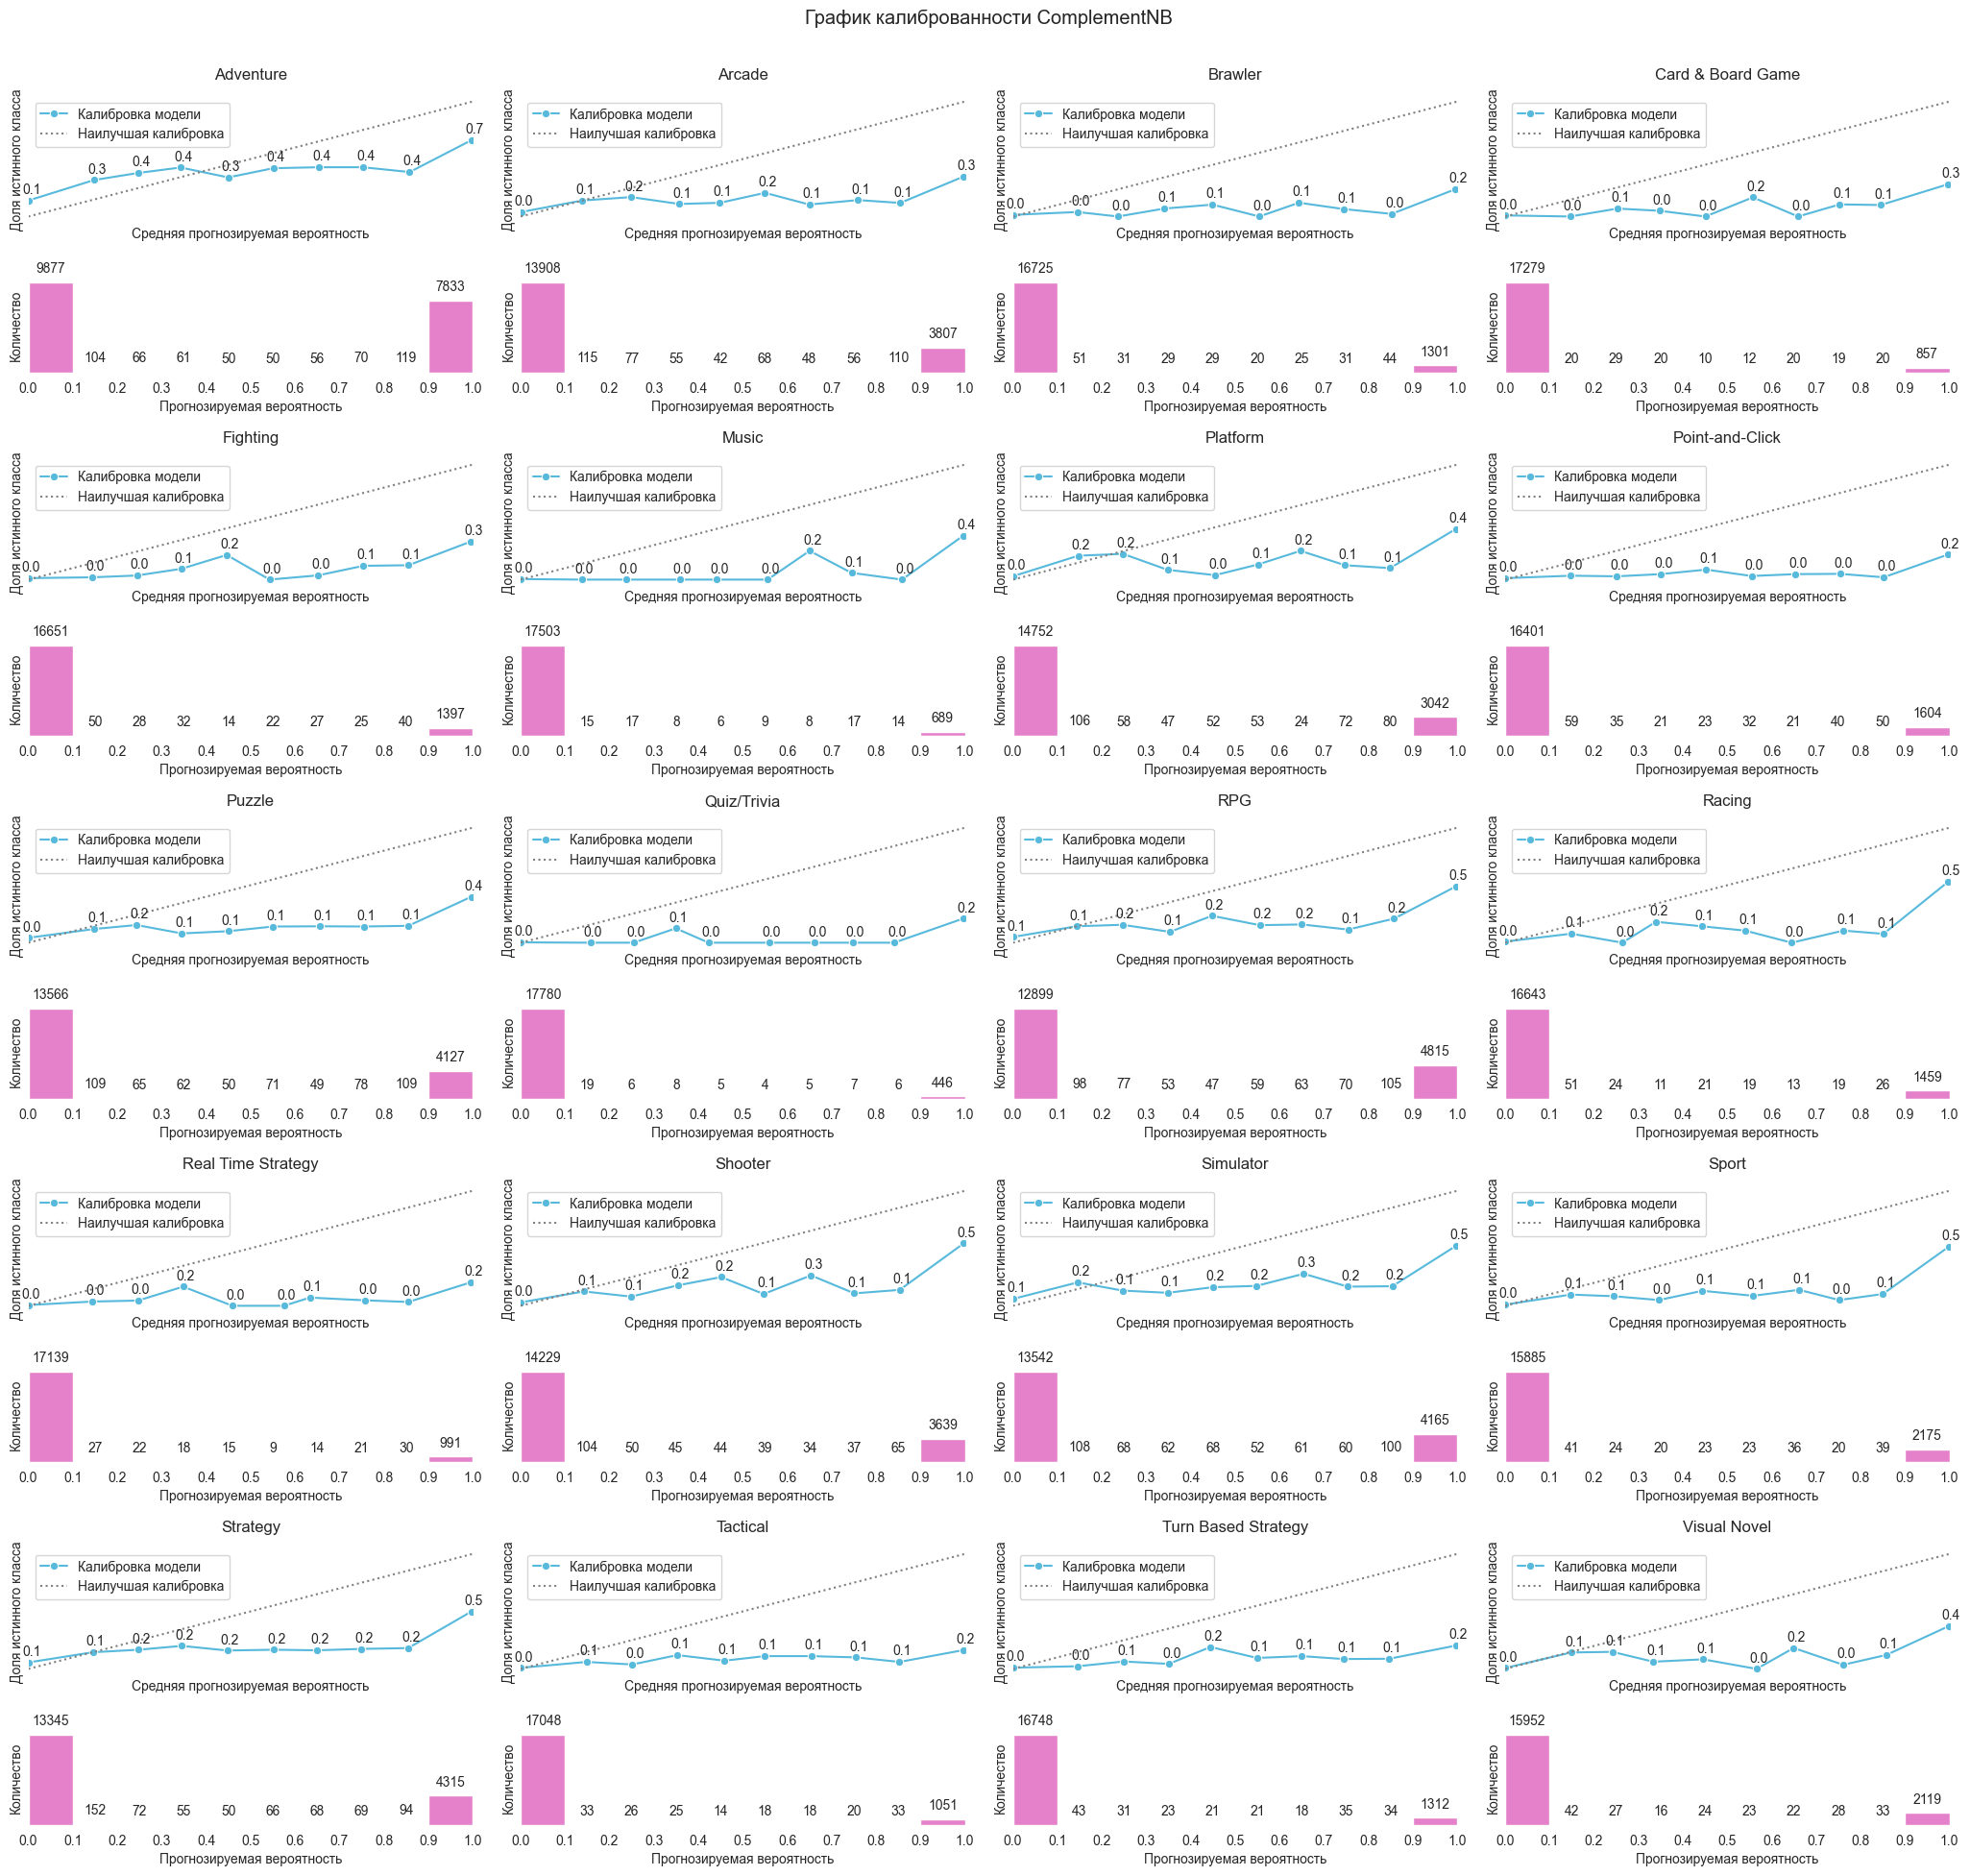

In [35]:
plot.calibration(
    y_true=y_valid,
    y_proba=[pd.DataFrame(x) for x in predict_proba], 
    labels=labels, 
    title='График калиброванности ComplementNB'
)

Модель имеет **низкую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу. Прогнозируемая вероятность распределена **неравномерно**, приобладают значения в диапазонах от **0.0** до **0.1** и от **0.9** до **1.0**. Вероятнее всего, это связанос тем, что модель наивного байеса считает признаки независимыми. **Необходима** калибровка модели. 

### Тестирование SGDClassifier
***

In [36]:
estimator = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    random_state=42
)

estimator = MultiOutputClassifier(
    estimator=estimator,
    n_jobs=4
)

pipeline = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator)
    ]
)
pipeline

Pipeline(steps=[('standardizer',
                 Pipeline(steps=[('vectorizer',
                                  TfidfVectorizer(stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
                                                              'your', 'yours',
                                                              'yourself',
                                                              'yourselves',
                                                              'he', 'him',
                                                              'his', 'himself',
                                                              'she', "she's",
                                                              'her', 'hers',
                                                              'herself', 'it',
                                                              "it's", 'its',
                                                              'itself', ...]))])),
                ('estimator',
                 MultiOutputClassifier(estimator=SGDClassifier(loss='log_loss',
                                                               penalty='elasticnet',
                                                               random_state=42),
                                       n_jobs=4))])

In [37]:
param_grid = {
    'standardizer__vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'standardizer__vectorizer__norm': [None, 'l1', 'l2'],
    'standardizer__vectorizer__sublinear_tf': [True],
    'standardizer__vectorizer__max_features': np.arange(
        start=750_000,
        stop=1_000_001,
        step=250_000
    ).tolist(),
    'estimator__estimator__alpha': np.linspace(
        start=0.1,
        stop=0.5,
        num=5
    ).round(5).tolist(),
    'estimator__estimator__class_weight': [None, 'balanced'],
    'estimator__estimator__l1_ratio': np.linspace(
        start=0.0,
        stop=0.5,
        num=6
    ).round(5).tolist()
}

In [38]:
best_param = {
    "estimator__estimator__alpha": [0.1],
    "estimator__estimator__class_weight": ["balanced"],
    "estimator__estimator__l1_ratio": [0.0],
    "standardizer__vectorizer__max_features": [1000000],
    "standardizer__vectorizer__ngram_range": [(1, 3)],
    'standardizer__vectorizer__sublinear_tf': [True],
    "standardizer__vectorizer__norm": [None]
}

In [39]:
%%time
sgd = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions=param_grid, 
    scoring=f1_weighted,
    error_score=0.0,
    n_iter=20,
    cv=2, 
    verbose=3,
    refit=True
)
sgd.fit(x_train, y_train); 

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2] END estimator__estimator__alpha=0.5, estimator__estimator__class_weight=None, estimator__estimator__l1_ratio=0.3, standardizer__vectorizer__max_features=750000, standardizer__vectorizer__ngram_range=(1, 1), standardizer__vectorizer__norm=l1, standardizer__vectorizer__sublinear_tf=True;, score=0.000 total time=  12.8s
[CV 2/2] END estimator__estimator__alpha=0.5, estimator__estimator__class_weight=None, estimator__estimator__l1_ratio=0.3, standardizer__vectorizer__max_features=750000, standardizer__vectorizer__ngram_range=(1, 1), standardizer__vectorizer__norm=l1, standardizer__vectorizer__sublinear_tf=True;, score=0.000 total time=  13.6s
[CV 1/2] END estimator__estimator__alpha=0.5, estimator__estimator__class_weight=None, estimator__estimator__l1_ratio=0.3, standardizer__vectorizer__max_features=1000000, standardizer__vectorizer__ngram_range=(1, 1), standardizer__vectorizer__norm=l2, standardizer__vectorizer__subli

In [40]:
cv_results = pd.DataFrame(
    data=sgd.cv_results_, 
).sort_values('rank_test_score')
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
16      40.809286      1.094667         7.858688        1.023785   
4        7.550694      1.376022         5.241207        1.067822   
19       7.398667      1.014630         4.206661        0.012759   
18      32.536379      0.507666         9.085747        1.992627   
15      33.843643      3.160444        10.745157        3.200443   
3       31.239343      1.912619        10.119065        0.529152   
11      32.034864      0.192176         9.921733        0.128641   
9       20.331866      1.170986         7.417574        1.488922   
6        4.289127      0.104580         2.952649        0.100092   
7       28.267873      4.060137         9.312755        0.722255   
8        4.785723      0.043605         2.843593        0.046454   
10      26.248427      0.598911         9.795073        0.344633   
5       26.889913      4.934229         6.636109        0.741420   
12      27.177406      0.686493        14.119152        5.938569   
13      12.557445      0.014149         7.888119        1.318558   
14      47.487516      9.138335        11.685741        1.782831   
2        7.227201      1.707502         3.657158        0.328445   
1        6.451148      0.411454         3.880255        0.040219   
17      48.694130      1.817094        10.124956        1.360947   
0        8.496327      0.155109         4.775848        0.557467   

   param_standardizer__vectorizer__sublinear_tf  \
16                                         True   
4                                          True   
19                                         True   
18                                         True   
15                                         True   
3                                          True   
11                                         True   
9                                          True   
6                                          True   
7                                          True   
8                                          True   
10                                         True   
5                                          True   
12                                         True   
13                                         True   
14                                         True   
2                                          True   
1                                          True   
17                                         True   
0                                          True   

   param_standardizer__vectorizer__norm  \
16                                 None   
4                                  None   
19                                 None   
18                                 None   
15                                 None   
3                                  None   
11                                   l1   
9                                    l1   
6                                    l1   
7                                    l2   
8                                    l1   
10                                   l2   
5                                    l2   
12                                 None   
13                                   l2   
14                                   l1   
2                                    l2   
1                                    l2   
17                                   l1   
0                                    l1   

   param_standardizer__vectorizer__ngram_range  \
16                                      (1, 3)   
4                                       (1, 1)   
19                                      (1, 1)   
18                                      (1, 3)   
15                                      (1, 3)   
3                                       (1, 2)   
11                                      (1, 3)   
9                                       (1, 2)   
6                                       (1, 1)   
7                                       (1, 3)   
8                                       (1, 1)   

In [41]:
results.loc['SGDClassifier', 'Время обучения'] = cv_results.iloc[0, -3]
results.loc['SGDClassifier', 'Время предсказания'] = cv_results.iloc[0, -3]
results.loc['SGDClassifier', 'f1-weighted'] = cv_results.iloc[0, -3]

In [42]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=sgd.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=ShuffleSplit(
        n_splits=LEARNING_CURVE_N_SPLITS,
        test_size=LEARNING_CURVE_TEST_SIZE,
        random_state=RANDOM_STATE
    ),
    n_jobs=N_JOBS,
    scoring=f1_weighted,
    return_times=True,
    verbose=3
)

[learning_curve] Training set sizes: [  682  3413 13653 27306 40960 54613 68267]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  35 | elapsed:  2.8min remaining:  5.4min
[Parallel(n_jobs=4)]: Done  24 out of  35 | elapsed:  6.1min remaining:  2.8min
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  9.9min finished


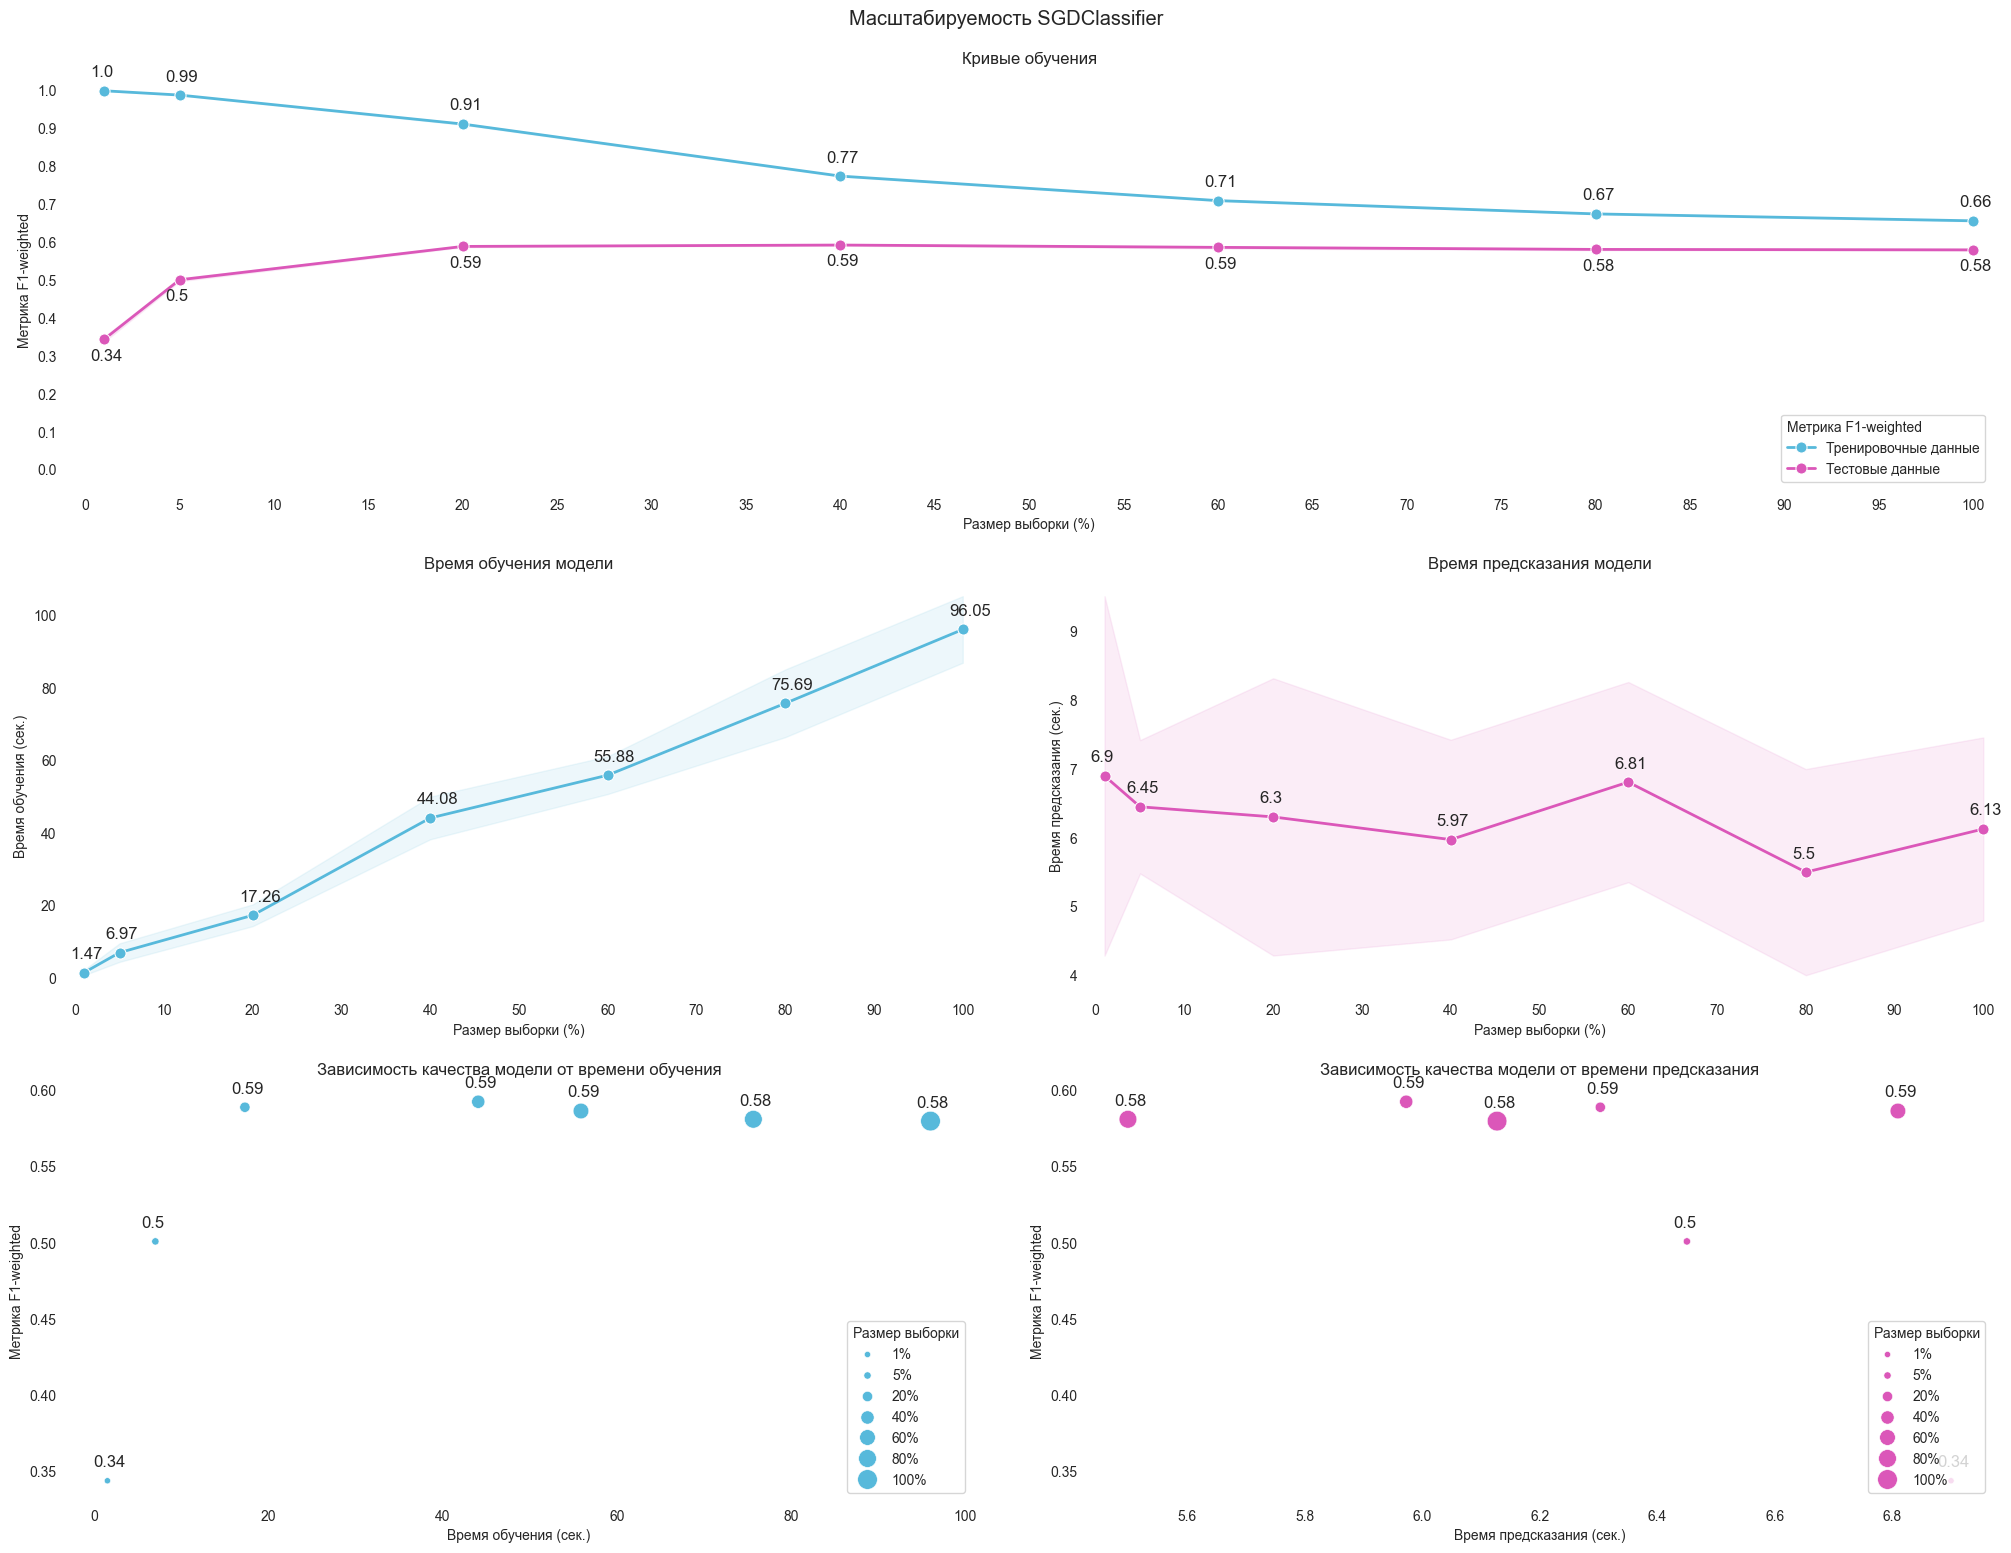

In [43]:
x_train_size = x_train.shape[0]
x_train_size *= (1 - LEARNING_CURVE_TEST_SIZE)
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость SGDClassifier',
)

Кривые обучения показывают, что **присутствует** признак переобучения модели. **Добавление новых данных не улучшит** предсказательную способность модели. При добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.

In [44]:
predict = sgd.predict(x_valid)
predict_proba = sgd.predict_proba(x_valid)

In [45]:
f1 = f1_score(
    y_true=y_valid,
    y_pred=predict,
    average='weighted'
)

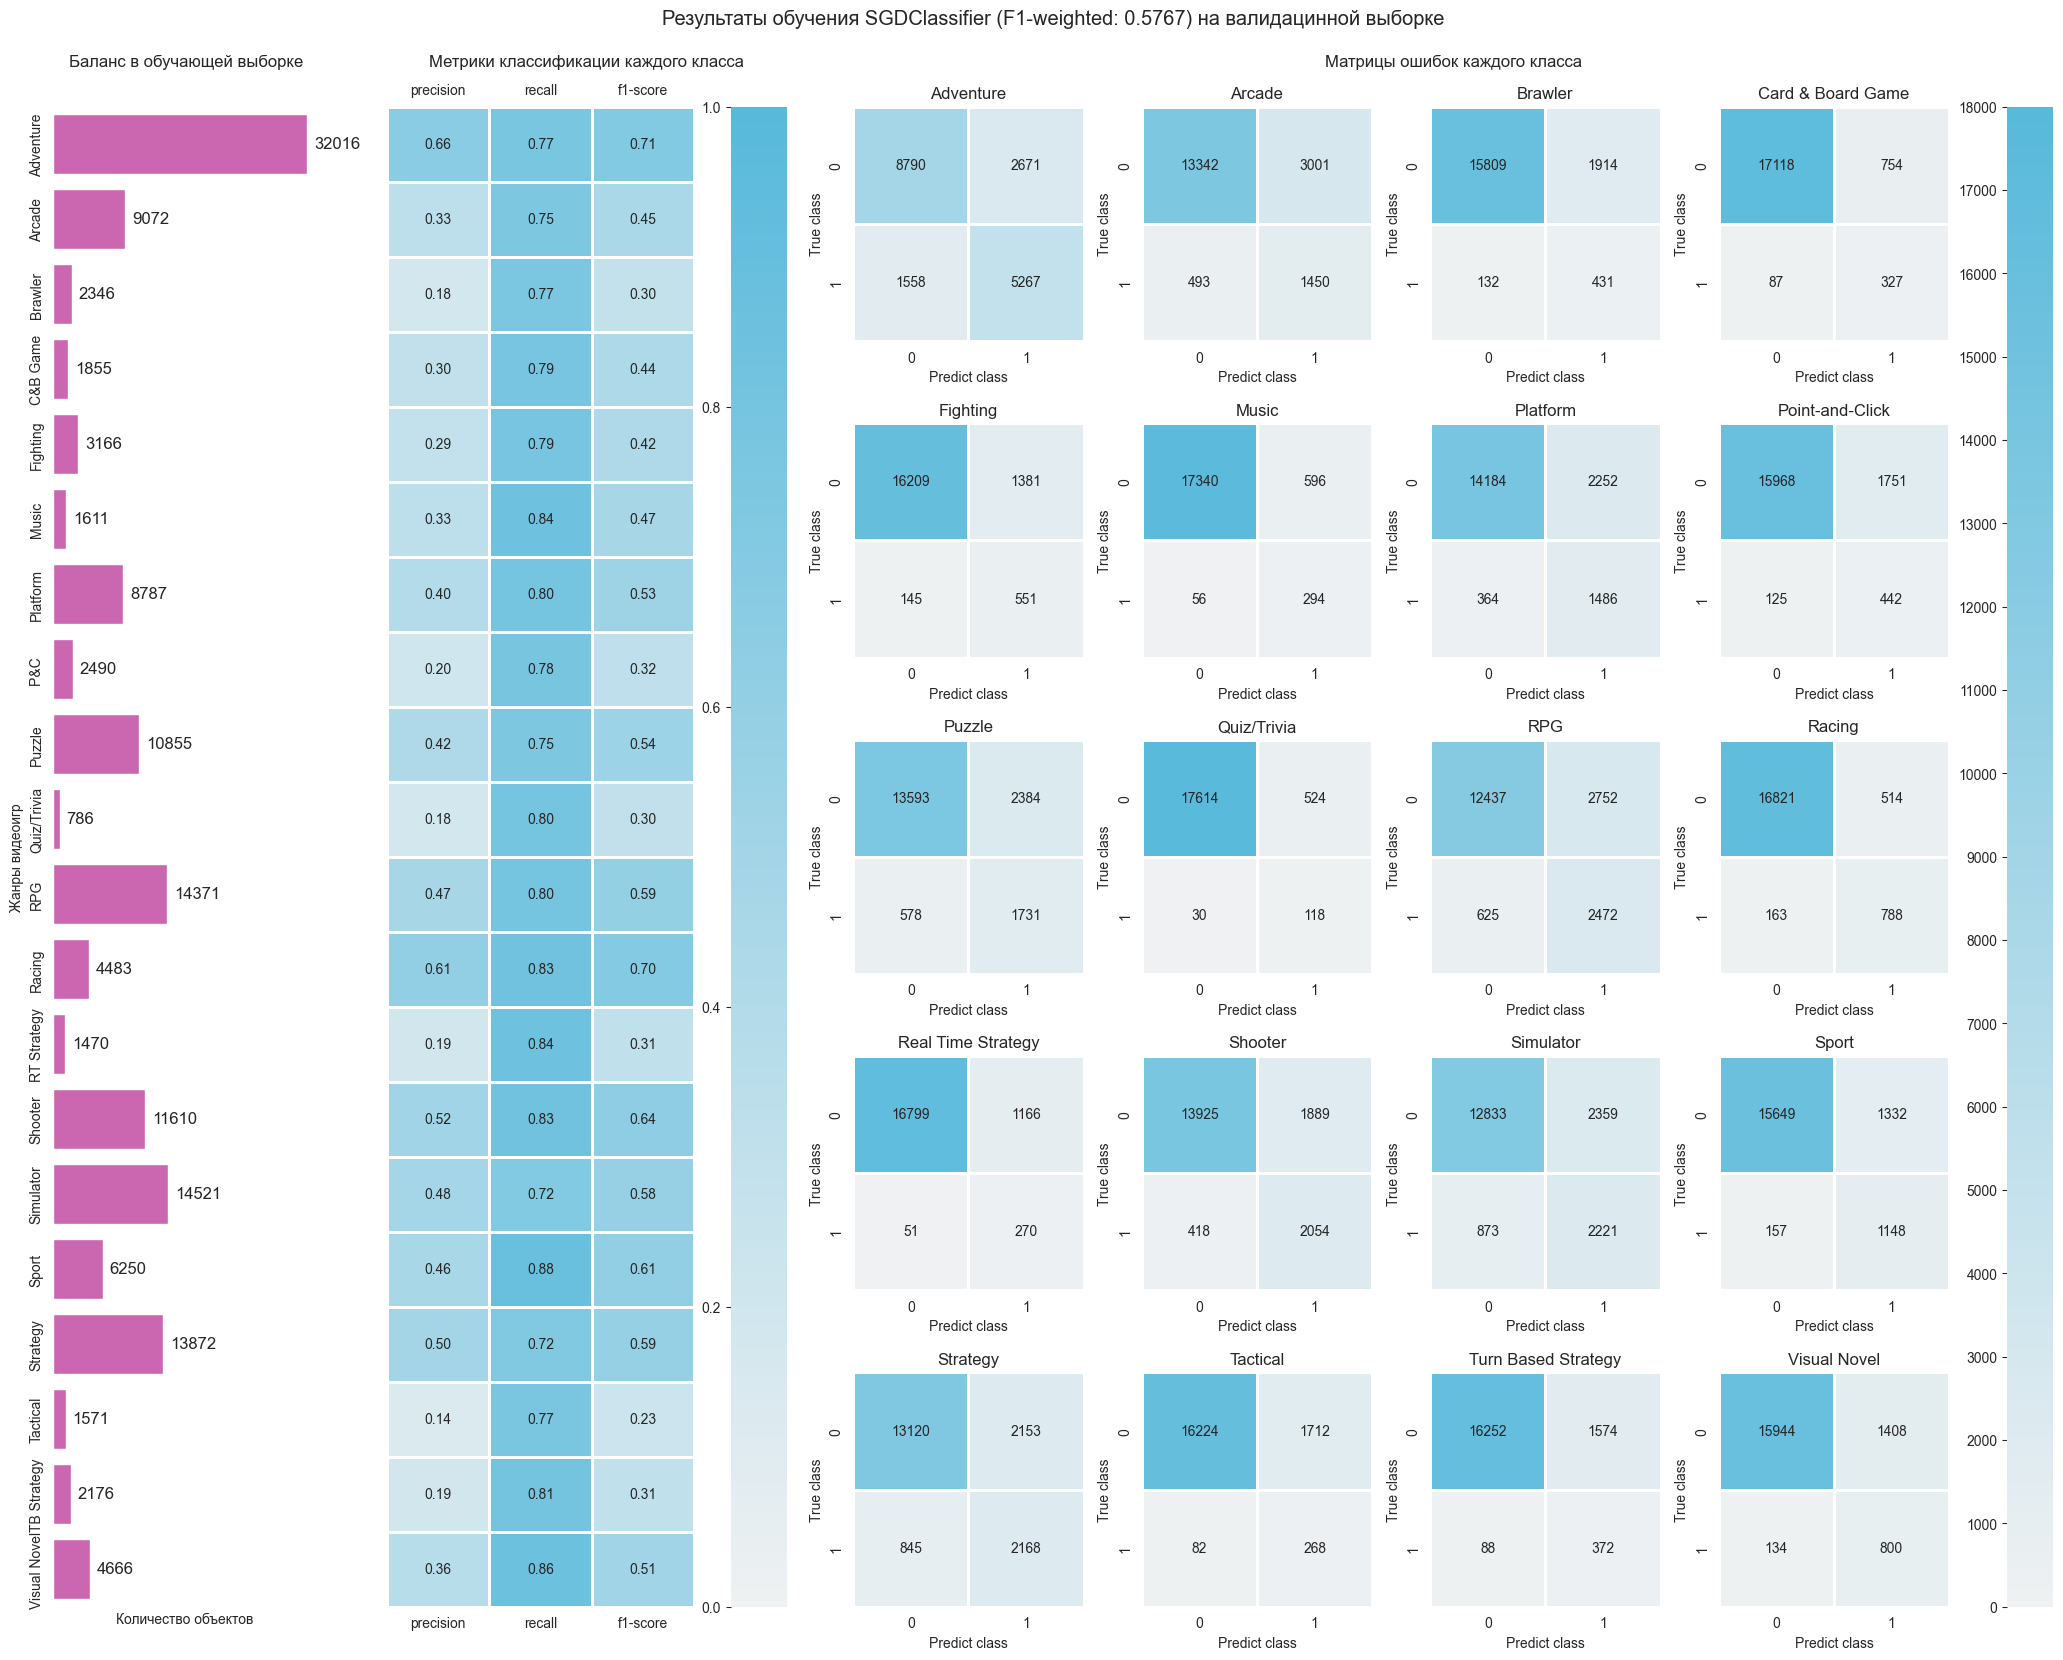

In [46]:
plot.metrics(
    y_test=y_valid,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения SGDClassifier '
          f'(F1-weighted: {f1:.4f}) на валидацинной выборке',
    labels=labels
)

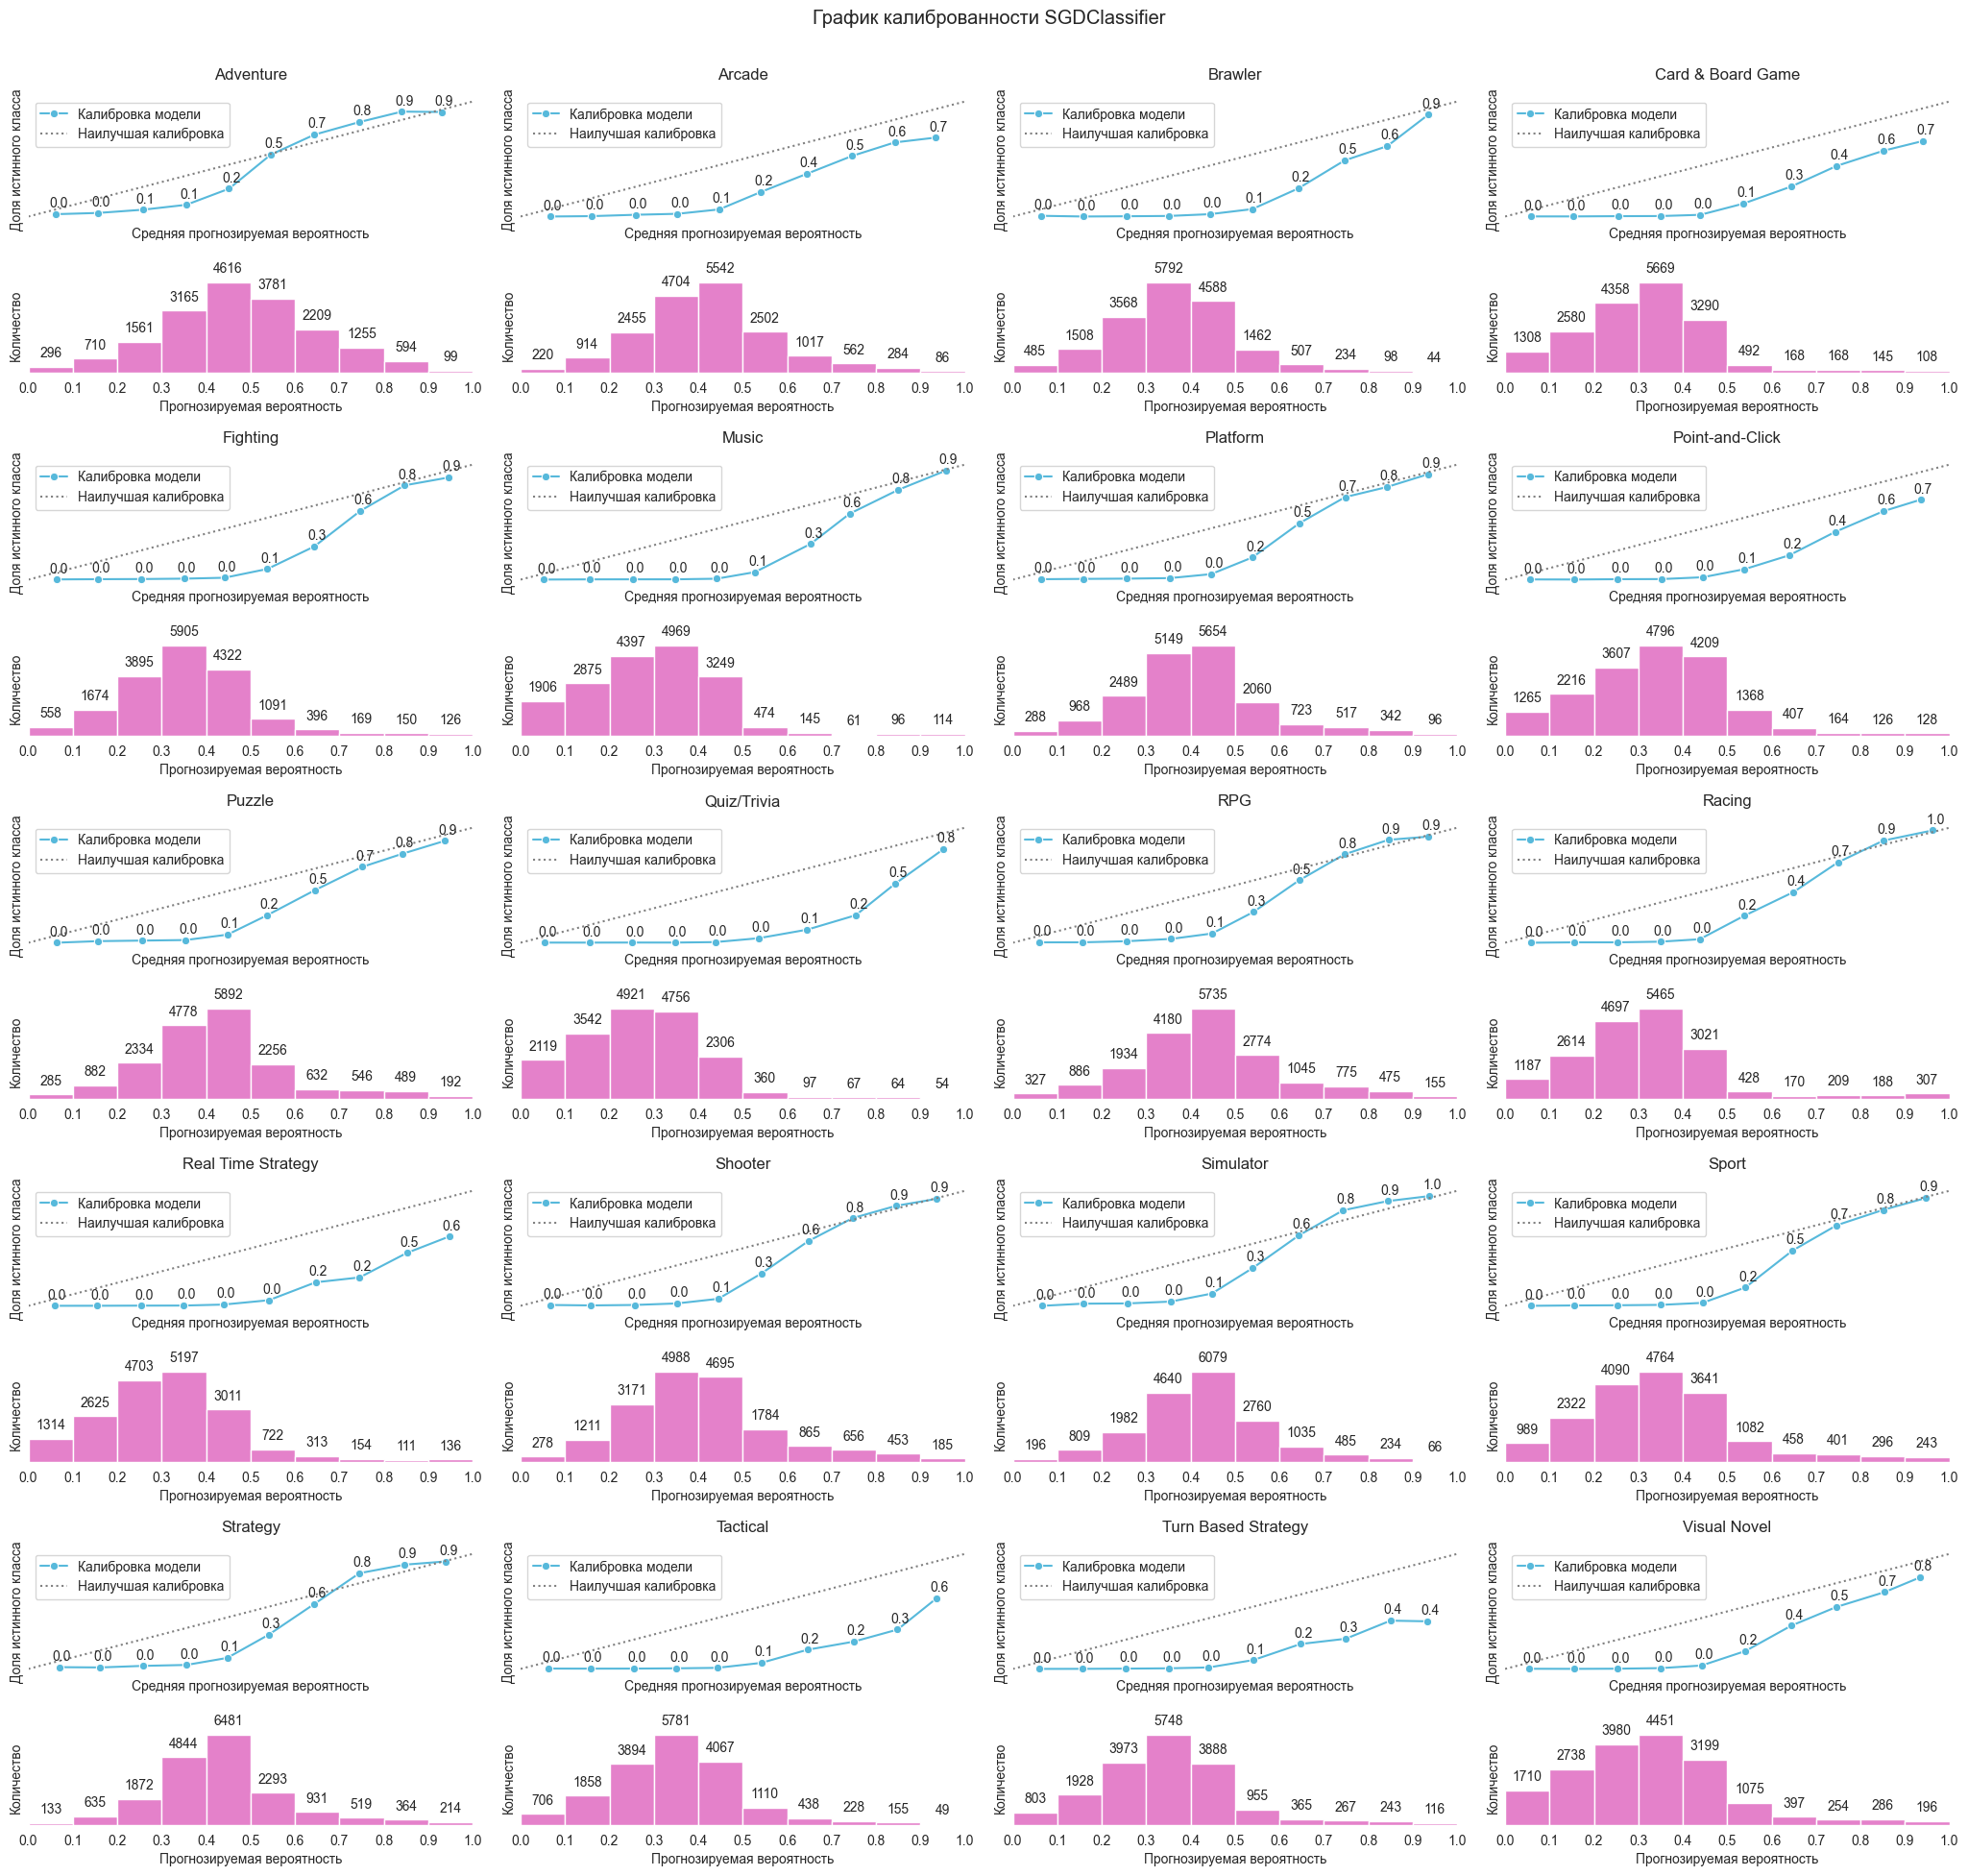

In [47]:
plot.calibration(
    y_true=y_valid,
    y_proba=[pd.DataFrame(x) for x in predict_proba],
    labels=labels, 
    title='График калиброванности SGDClassifier'
)

### Выводы по тестированию моделей
***

1. Для стандартизации признаков использован **TfidfVectorizer**.
2. Дляля оценки эффективности **предсказательной способности** модели использована метрика **f1-weighted**.
3. Для **оценки эффективности** были выбраны следующие показатели:
    - время обучения;
    - время предсказания;
    - f1-weighted.
4. ComplementNB:
    - результаты кросс-валидации:
        - среднее время обучения: от **15** до **20** сек.;
        - среднее время предсказания: от **3** до **5** сек.;
        - среднее значение f1-weighted: **0.59**.
    - оценка масштабируемости:
        - кривые обучения показывают, что **присутствует** признак переобучения модели;
        - **добавление новых данных** возможно **улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
    - на валидационной выборке значение f1-weighted - **0.60**
    - калиброванность модели:
        - модель имеет **низкую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
        - прогнозируемая вероятность распределена **неравномерно**, приобладают значения в диапазонах от **0.0** до **0.1** и от **0.9** до **1.0**;
        - вероятнее всего, это связанос тем, что модель наивного байеса считает признаки независимыми;
        - **необходима** калибровка модели.  
5. SGDClassifier:
    - результаты кросс-валидации:
        - среднее время обучения: от **20** до **25** сек.;
        - среднее время предсказания:от **3** до **5** сек.;
        - среднее значение f1-weighted: **0.60**.
    - оценка масштабируемости:
        - кривые обучения показывают, что **присутствует** признак переобучения модели;
        - **добавление новых данных не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
    - на валидационной выборке значение f1-weighted - **0.60**
    - калиброванность модели:
        - модель имеет **неплохую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
        - прогнозируемая вероятность распределена **неравномерно**, тем не менее, **отсутствуют** явно приобладающие диапазоны;
        - для более точного прогнозирования вероятности **необходима** калибровка модели.

## Проверка модели на тестовой выборке
***

In [48]:
(results
 .style
 .format(lambda x: f'{x:.3f}'))

In [49]:
predict = sgd.predict(x_test)

In [50]:
f1 = f1_score(
    y_true=y_test,
    y_pred=predict,
    average='weighted'
)

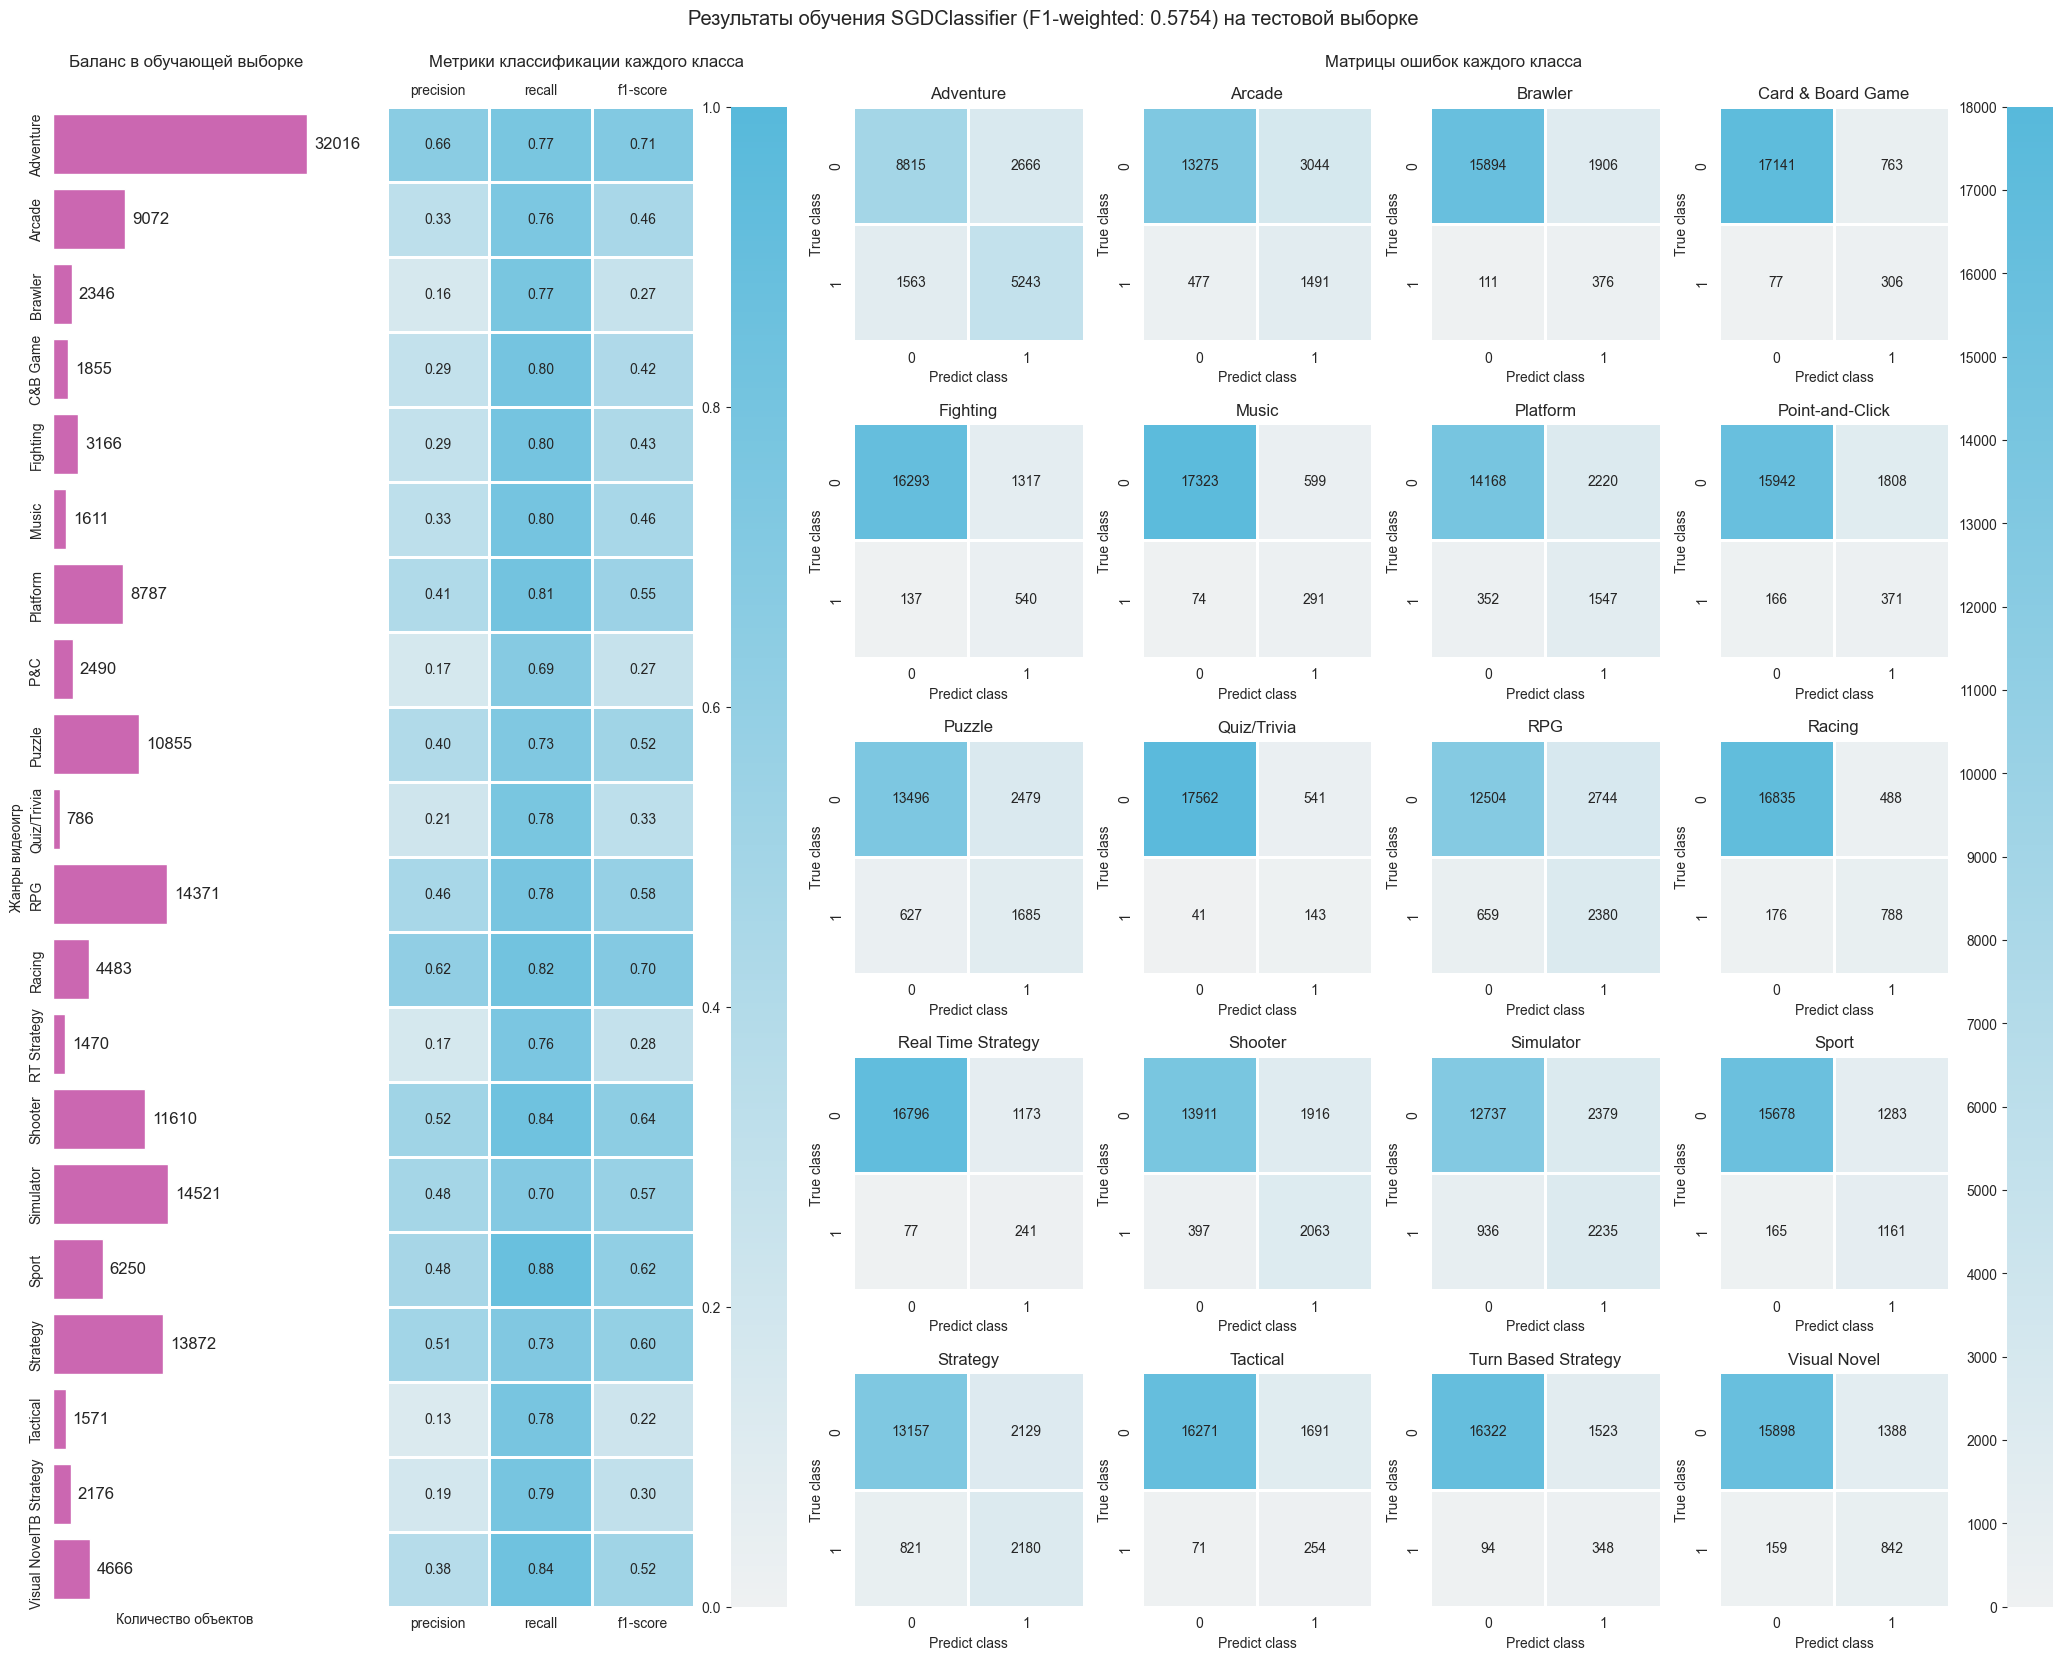

In [51]:
plot.metrics(
    y_test=y_test,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения SGDClassifier '
          f'(F1-weighted: {f1:.4f}) на тестовой выборке',
    labels=labels
)

## Сравнение с простым классификатором 

In [52]:
dummy_clf = DummyClassifier(
    strategy='stratified',
    random_state=RANDOM_STATE
)
dummy_clf.fit(x_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

In [53]:
predict = pd.DataFrame(dummy_clf.predict(x_test))

In [54]:
f1 = f1_score(
    y_true=y_test,
    y_pred=predict,
    average='weighted'
)

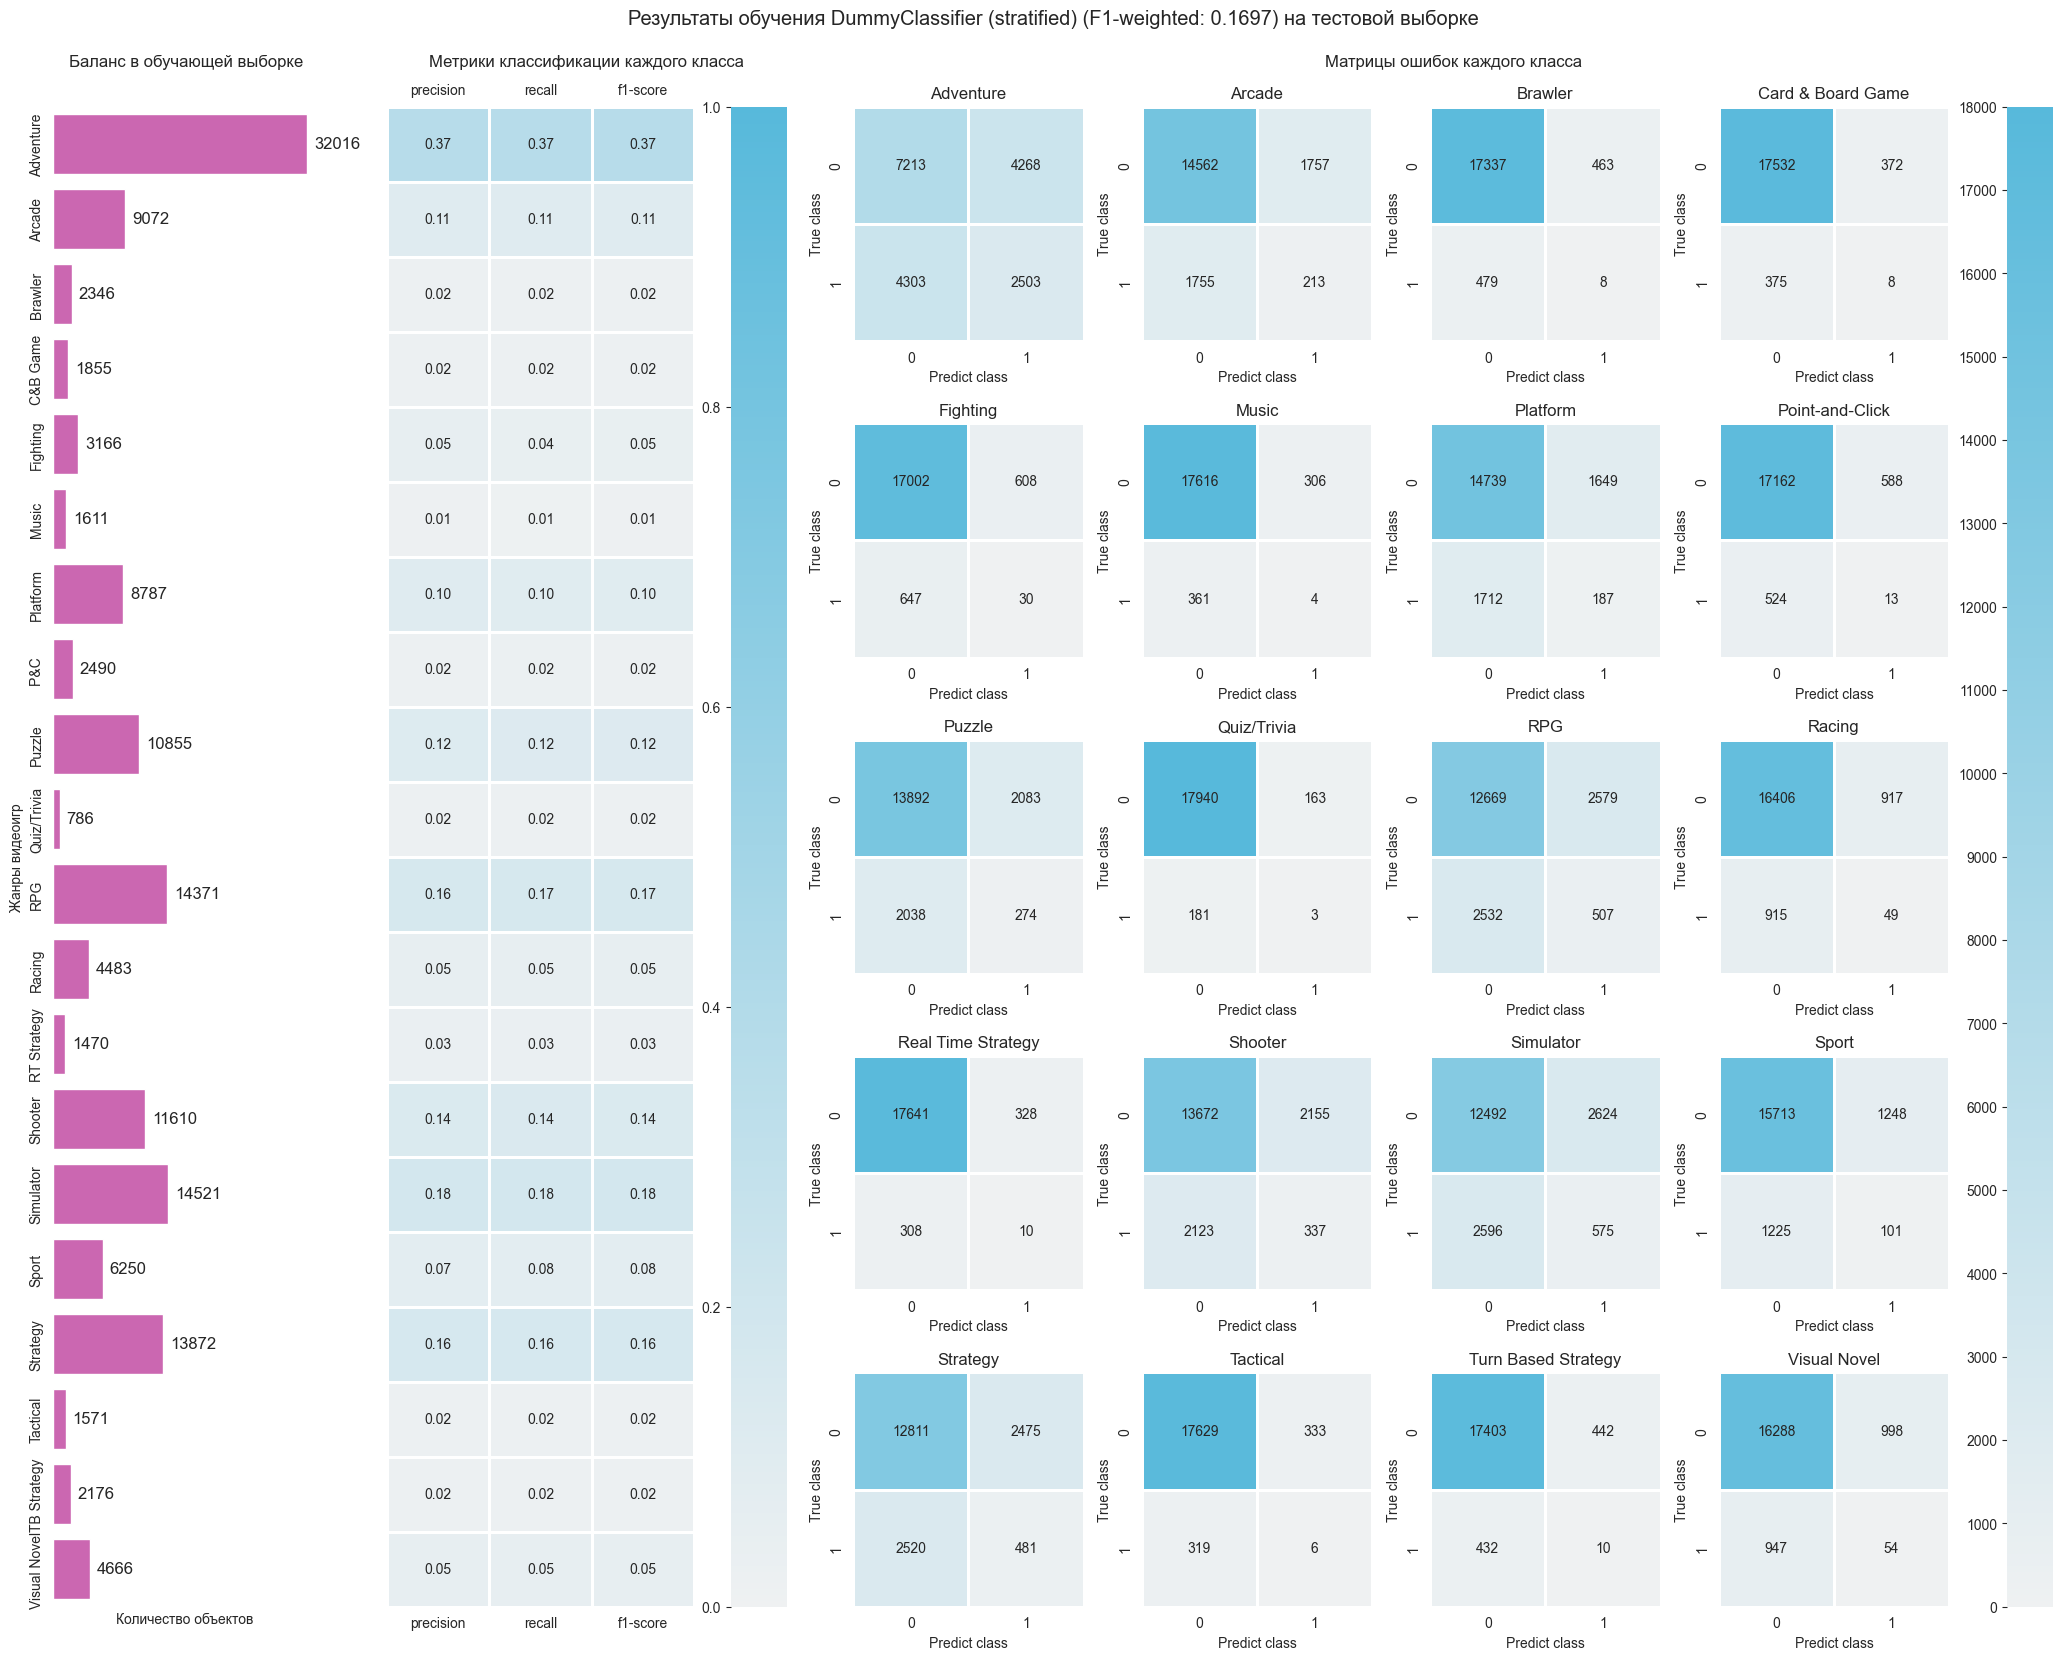

In [55]:
plot.metrics(
    y_test=y_test,
    y_predict=pd.DataFrame(predict),
    y_train=y_train,
    title=f'Результаты обучения DummyClassifier (stratified) '
          f'(F1-weighted: {f1:.4f}) на тестовой выборке',
    labels=labels
)

# Выводы
***

1. Были отобраны описания видеоигр только с ascii символами.
2. Описания объеденены с **20 наиболее популярными** жанрами.
3. Предварительная обработка текста:
    - описание видеоигр **очищено** от символов, отличных от символов **латинского алфавита**.
    - проведена **лемматизация** текста.
    - **удалены** записи с описанием менее **100 символов**;
4. Данные поделены на **тренировочную**, **валидационную** и **тестовую** выборки в отношении **7:1.5:1.5**.
5. Анализ баланса классов:
    - в наборе данных **присутствует дисбаланс классов**;
    - **мажоритарным** классом является класс **Adventure** (количество экземпляров более **29 тыс.**);
    - **миноритарным** классом является класс **Quiz/Trivia** (количество экземпляров менее **1 тыс.**);
    - **остальные** классы имеют от **800** до **13 тыс.** экземпляров.
6. Частотный анализ:
    - наиболее часто в описаниях видеоигр встречается слово **game** (приблизительно **70 тыс.** раз);
    - **остальные слова** встречаются в описаниях видеоигр менее **20 тыс.** раз;
    - для каждого класса существует свой **уникальный** список наиболее часто встречающихся слов в описаниях видеоигр.
7. Тестирование моделей:
    - Для стандартизации признаков использован **TfidfVectorizer**.
    - Дляля оценки эффективности **предсказательной способности** модели использована метрика **f1-weighted**.
    - Для **оценки эффективности** были выбраны следующие показатели:
        - время обучения;
        - время предсказания;
        - f1-weighted.
    1. ComplementNB:
        - результаты кросс-валидации:
            - среднее время обучения: от **15** до **20** сек.;
            - среднее время предсказания: от **3** до **5** сек.;
            - среднее значение f1-weighted: **0.59**.
        - оценка масштабируемости:
            - кривые обучения показывают, что **присутствует** признак переобучения модели;
            - **добавление новых данных** возможно **улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
        - на валидационной выборке значение f1-weighted - **0.60**
        - калиброванность модели:
            - модель имеет **низкую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
            - прогнозируемая вероятность распределена **неравномерно**, приобладают значения в диапазонах от **0.0** до **0.1** и от **0.9** до **1.0**;
            - вероятнее всего, это связанос тем, что модель наивного байеса считает признаки независимыми;
            - **необходима** калибровка модели.  
    2. SGDClassifier:
        - результаты кросс-валидации:
            - среднее время обучения: от **20** до **25** сек.;
            - среднее время предсказания:от **3** до **5** сек.;
            - среднее значение f1-weighted: **0.60**.
        - оценка масштабируемости:
            - кривые обучения показывают, что **присутствует** признак переобучения модели;
            - **добавление новых данных не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** возрастает **линейно**; **время предсказания** - **не зименяется**.
        - на валидационной выборке значение f1-weighted - **0.60**
        - калиброванность модели:
            - модель имеет **неплохую точность** прогнозирования вероятности принадлежности объекта к тому или иному классу;
            - прогнозируемая вероятность распределена **неравномерно**, тем не менее, **отсутствуют** явно приобладающие диапазоны;
            - для более точного прогнозирования вероятности **необходима** калибровка модели.
8. Проверка модели на тестовой выборке:
    - выбрана модель **SGDClassifier**;
    - значение f1-weighted: **0.59**.
9. Сравнение с простым классификатором:
    - в качестве простого классификатора выбран **DummyClassifier (stratified)**;
    - значение f1-weighted: **0.16**